<h1 style="text-align: center; font-family: 'Lucida Console', 'Courier New', monospace;">Japan Real Estate Prices</h1>

<img src="https://iili.io/HxDtxZ7.jpg" alt="japan" border="0">

## About Dataset

This dataset is a record of real estate transaction prices in Japan from 2005 to 2019, surveyed by the MLIT (Ministry of Land, Infrastructure, Transport and Tourism of Japan). It contains all 47 prefectures from Hokkaido (北海道 - 1) to Okinawa (沖縄県 - 47).

### Creating Spark Session and Importing Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder \
    .appName("final_project") \
    .getOrCreate() 

sc = spark.sparkContext

### Reading the datasets
Only few prefectures were selected for data analysis. Three main prefectures that I have chosen are Tokyo, Osaka and Fukuoka. Saitama and Kanagawa are popular smaller prefectures near Tokyo. They were chosen for comparison.
#### Saitama (埼玉県)

In [2]:
df_11 = spark.read.csv('11.csv', inferSchema=True, header = True)

#### Tokyo (東京都)

In [3]:
df_13 = spark.read.csv('13.csv', inferSchema=True, header = True)

#### Kanagawa (神奈川県)

In [4]:
df_14 = spark.read.csv('14.csv', inferSchema=True, header = True)

#### Osaka (大阪府)

In [5]:
df_27 = spark.read.csv('27.csv', inferSchema=True, header = True)

#### Fukuoka (福岡県)

In [6]:
df_40 = spark.read.csv('40.csv', inferSchema=True, header = True)

### DataFrame Overview

In [7]:
df_11.toPandas()

,No,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,...,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,Remarks
0,1,Residential Land(Land and Building),Residential Area,11101,Saitama Prefecture,"Nishi Ward,Saitama City",Oaza Iida,Omiya (Saitama),30-60minutes,30.0,...,Private Road,6.0,Urbanization Control Area,NaN,NaN,2nd quarter 2019,2019,2,None,None
1,2,Residential Land(Land Only),Residential Area,11101,Saitama Prefecture,"Nishi Ward,Saitama City",Oaza Iida,Omiya (Saitama),30-60minutes,30.0,...,City Road,5.5,Urbanization Control Area,60.0,200.0,1st quarter 2019,2019,1,None,None
2,3,Residential Land(Land and Building),Residential Area,11101,Saitama Prefecture,"Nishi Ward,Saitama City",Oaza Iida,Omiya (Saitama),30-60minutes,30.0,...,City Road,3.6,Urbanization Control Area,NaN,NaN,3rd quarter 2018,2018,3,None,None
3,4,Residential Land(Land Only),Residential Area,11101,Saitama Prefecture,"Nishi Ward,Saitama City",Oaza Iida,Omiya (Saitama),30-60minutes,30.0,...,City Road,6.5,Urbanization Control Area,NaN,NaN,1st quarter 2018,2018,1,None,None
4,5,Residential Land(Land Only),Residential Area,11101,Saitama Prefecture,"Nishi Ward,Saitama City",Oaza Iida,Omiya (Saitama),30-60minutes,30.0,...,City Road,6.0,Urbanization Control Area,NaN,NaN,2nd quarter 2016,2016,2,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208952,208953,Residential Land(Land and Building),Residential Area,11465,Saitama Prefecture,"Matsubushi Town,Kitakatsushika County",Yumeminohigashi,Kitakoshigaya,1H-1H30,60.0,...,Town Road,4.0,Category I Exclusively Low-story Residential Zone,50.0,80.0,3rd quarter 2008,2008,3,None,None
208953,208954,Residential Land(Land and Building),Residential Area,11465,Saitama Prefecture,"Matsubushi Town,Kitakatsushika County",Yumeminohigashi,Kitakoshigaya,1H-1H30,60.0,...,Town Road,4.0,Category I Exclusively Medium-high Residential...,50.0,100.0,3rd quarter 2008,2008,3,None,None
208954,208955,Residential Land(Land and Building),Residential Area,11465,Saitama Prefecture,"Matsubushi Town,Kitakatsushika County",Yumeminohigashi,Kitakoshigaya,1H-1H30,60.0,...,Town Road,6.0,Category I Exclusively Low-story Residential Zone,50.0,80.0,1st quarter 2008,2008,1,None,None
208955,208956,Residential Land(Land Only),Residential Area,11465,Saitama Prefecture,"Matsubushi Town,Kitakatsushika County",Yumeminohigashi,Kitakoshigaya,1H-1H30,60.0,...,Town Road,6.0,Category I Exclusively Medium-high Residential...,50.0,100.0,3rd quarter 2007,2007,3,None,None


In [8]:
df_13.toPandas()

,No,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,...,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,Remarks
0,1,"Pre-owned Condominiums, etc.",None,13101,Tokyo,Chiyoda Ward,Iidabashi,Iidabashi,4,4.0,...,None,NaN,Commercial Zone,80.0,500.0,3rd quarter 2019,2019,3,Not yet,None
1,2,"Pre-owned Condominiums, etc.",None,13101,Tokyo,Chiyoda Ward,Iidabashi,Iidabashi,4,4.0,...,None,NaN,Commercial Zone,80.0,500.0,3rd quarter 2019,2019,3,Done,None
2,3,Residential Land(Land and Building),Commercial Area,13101,Tokyo,Chiyoda Ward,Iidabashi,Iidabashi,2,2.0,...,Ward Road,4.0,Commercial Zone,80.0,500.0,2nd quarter 2019,2019,2,None,None
3,4,Residential Land(Land and Building),Commercial Area,13101,Tokyo,Chiyoda Ward,Iidabashi,Iidabashi,1,1.0,...,Tokyo Metropolitan Road,27.0,Commercial Zone,80.0,700.0,2nd quarter 2019,2019,2,None,None
4,5,"Pre-owned Condominiums, etc.",None,13101,Tokyo,Chiyoda Ward,Iidabashi,Iidabashi,4,4.0,...,None,NaN,Commercial Zone,80.0,500.0,2nd quarter 2019,2019,2,Done,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406570,406571,Residential Land(Land Only),Potential Residential Area,13421,Tokyo,Ogasawara Village,Chichijima,None,None,NaN,...,None,NaN,Non-divided City Planning Area,70.0,200.0,1st quarter 2007,2007,1,None,None
406571,406572,Residential Land(Land Only),Potential Residential Area,13421,Tokyo,Ogasawara Village,Chichijima,None,None,NaN,...,Village Road,5.5,Non-divided City Planning Area,70.0,200.0,1st quarter 2007,2007,1,None,None
406572,406573,Residential Land(Land Only),Residential Area,13421,Tokyo,Ogasawara Village,Hahajima,None,None,NaN,...,Village Road,4.8,Non-divided City Planning Area,70.0,200.0,3rd quarter 2008,2008,3,None,Dealings of adjacent land
406573,406574,Residential Land(Land Only),Potential Residential Area,13421,Tokyo,Ogasawara Village,Hahajima,None,None,NaN,...,None,NaN,Non-divided City Planning Area,70.0,200.0,4th quarter 2007,2007,4,None,Dealings of adjacent land


In [9]:
df_14.toPandas()

,No,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,...,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,Remarks
0,1,Residential Land(Land and Building),Residential Area,14101,Kanagawa Prefecture,"Tsurumi Ward,Yokohama City",Asahicho,Asano,11,11.0,...,Private Road,4.2,Quasi-industrial Zone,60.0,200.0,4th quarter 2017,2017,4,None,None
1,2,Residential Land(Land and Building),Residential Area,14101,Kanagawa Prefecture,"Tsurumi Ward,Yokohama City",Asahicho,Asano,11,11.0,...,City Road,4.2,Quasi-industrial Zone,60.0,200.0,3rd quarter 2017,2017,3,None,None
2,3,"Pre-owned Condominiums, etc.",None,14101,Kanagawa Prefecture,"Tsurumi Ward,Yokohama City",Asahicho,Asano,6,6.0,...,None,NaN,Quasi-industrial Zone,60.0,200.0,3rd quarter 2017,2017,3,None,None
3,4,"Pre-owned Condominiums, etc.",None,14101,Kanagawa Prefecture,"Tsurumi Ward,Yokohama City",Asahicho,Asano,6,6.0,...,None,NaN,Quasi-industrial Zone,60.0,200.0,3rd quarter 2017,2017,3,Not yet,None
4,5,"Pre-owned Condominiums, etc.",None,14101,Kanagawa Prefecture,"Tsurumi Ward,Yokohama City",Asahicho,Asano,10,10.0,...,None,NaN,Quasi-industrial Zone,60.0,200.0,1st quarter 2015,2015,1,Not yet,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279961,279962,Agricultural Land,None,14402,Kanagawa Prefecture,"Kiyokawa Village,Aiko County",Susugaya,None,None,NaN,...,None,NaN,None,NaN,NaN,1st quarter 2008,2008,1,None,None
279962,279963,Forest Land,None,14402,Kanagawa Prefecture,"Kiyokawa Village,Aiko County",Susugaya,None,None,NaN,...,None,NaN,None,NaN,NaN,4th quarter 2007,2007,4,None,None
279963,279964,Forest Land,None,14402,Kanagawa Prefecture,"Kiyokawa Village,Aiko County",Susugaya,None,None,NaN,...,None,NaN,None,NaN,NaN,1st quarter 2007,2007,1,None,None
279964,279965,Residential Land(Land Only),Residential Area,14402,Kanagawa Prefecture,"Kiyokawa Village,Aiko County",Miyagase,Hon-atsugi,2H-,120.0,...,Prefectural Road,12.0,Outside City Planning Area,NaN,NaN,3rd quarter 2007,2007,3,None,None


In [10]:
df_27.toPandas()

,No,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,...,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,Remarks
0,1,Residential Land(Land and Building),Residential Area,27102,Osaka Prefecture,"Miyakojima Ward,Osaka City",Amijimacho,Osakajokitazume,2,2.0,...,City Road,8.0,Category II Residential Zone,80.0,300.0,3rd quarter 2019,2019,3,None,None
1,2,"Pre-owned Condominiums, etc.",None,27102,Osaka Prefecture,"Miyakojima Ward,Osaka City",Amijimacho,Osakajokitazume,5,5.0,...,None,NaN,Category II Residential Zone,80.0,300.0,3rd quarter 2019,2019,3,Not yet,None
2,3,"Pre-owned Condominiums, etc.",None,27102,Osaka Prefecture,"Miyakojima Ward,Osaka City",Amijimacho,Osakajokitazume,5,5.0,...,None,NaN,Category II Residential Zone,80.0,300.0,2nd quarter 2019,2019,2,Done,None
3,4,"Pre-owned Condominiums, etc.",None,27102,Osaka Prefecture,"Miyakojima Ward,Osaka City",Amijimacho,Osakajokitazume,5,5.0,...,None,NaN,Category II Residential Zone,80.0,300.0,1st quarter 2019,2019,1,Not yet,None
4,5,"Pre-owned Condominiums, etc.",None,27102,Osaka Prefecture,"Miyakojima Ward,Osaka City",Amijimacho,Osakajokitazume,5,5.0,...,None,NaN,Category II Residential Zone,80.0,300.0,4th quarter 2018,2018,4,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234751,234752,Forest Land,None,27383,Osaka Prefecture,"Chihayaakasaka Village,Minamikawachi County",Oaza Kobuki,None,None,NaN,...,None,NaN,None,NaN,NaN,2nd quarter 2007,2007,2,None,None
234752,234753,Residential Land(Land Only),Residential Area,27383,Osaka Prefecture,"Chihayaakasaka Village,Minamikawachi County",Oaza Moriya,Tondabayashi,1H-1H30,60.0,...,Town Road,2.7,Category I Residential Zone,60.0,200.0,3rd quarter 2008,2008,3,None,None
234753,234754,Residential Land(Land Only),Residential Area,27383,Osaka Prefecture,"Chihayaakasaka Village,Minamikawachi County",Oaza Moriya,Tondabayashi,1H-1H30,60.0,...,Village Road,4.7,Category I Residential Zone,60.0,200.0,3rd quarter 2008,2008,3,None,None
234754,234755,Residential Land(Land and Building),Industrial Area,27383,Osaka Prefecture,"Chihayaakasaka Village,Minamikawachi County",Oaza Moriya,Tondabayashi,1H-1H30,60.0,...,Kyoto/ Osaka Prefectural Road,7.0,Urbanization Control Area,60.0,200.0,2nd quarter 2008,2008,2,None,None


In [11]:
df_40.toPandas()

,No,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,...,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,Remarks
0,1,Residential Land(Land Only),Residential Area,40101,Fukuoka Prefecture,"Moji Ward,Kitakyushu City",Aobadai,Moji,30-60minutes,30.0,...,Road,4.0,Category I Exclusively Low-story Residential Zone,50.0,80.0,4th quarter 2017,2017,4,None,None
1,2,Residential Land(Land Only),Residential Area,40101,Fukuoka Prefecture,"Moji Ward,Kitakyushu City",Oaza Ikawa,Komorie,30-60minutes,30.0,...,City Road,4.0,Urbanization Control Area,NaN,NaN,1st quarter 2018,2018,1,None,None
2,3,Residential Land(Land Only),Residential Area,40101,Fukuoka Prefecture,"Moji Ward,Kitakyushu City",Oaza Ikawa,Moji,1H-1H30,60.0,...,City Road,4.0,Urbanization Control Area,NaN,NaN,4th quarter 2017,2017,4,None,None
3,4,Residential Land(Land Only),Residential Area,40101,Fukuoka Prefecture,"Moji Ward,Kitakyushu City",Oaza Ikawa,Moji,1H-1H30,60.0,...,Prefectural Road,35.0,Urbanization Control Area,70.0,200.0,4th quarter 2016,2016,4,None,None
4,5,Residential Land(Land Only),Residential Area,40101,Fukuoka Prefecture,"Moji Ward,Kitakyushu City",Oaza Ikawa,Moji,1H-1H30,60.0,...,None,NaN,Urbanization Control Area,70.0,200.0,3rd quarter 2016,2016,3,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137362,137363,Residential Land(Land Only),Residential Area,40647,Fukuoka Prefecture,"Chikujo Town,Chikujo County",Oaza Minato,Shiida,9,9.0,...,National Highway,10.0,Category I Residential Zone,60.0,200.0,1st quarter 2008,2008,1,None,None
137363,137364,Residential Land(Land Only),Residential Area,40647,Fukuoka Prefecture,"Chikujo Town,Chikujo County",Oaza Minato,Shiida,5,5.0,...,Town Road,3.0,Category I Residential Zone,60.0,200.0,3rd quarter 2006,2006,3,None,None
137364,137365,Residential Land(Land Only),Residential Area,40647,Fukuoka Prefecture,"Chikujo Town,Chikujo County",Oaza Minato,Shiida,9,9.0,...,Town Road,2.0,Category I Residential Zone,60.0,200.0,3rd quarter 2006,2006,3,None,None
137365,137366,Residential Land(Land Only),Residential Area,40647,Fukuoka Prefecture,"Chikujo Town,Chikujo County",Oaza Minato,Shiida,13,13.0,...,Town Road,3.5,Non-divided City Planning Area,60.0,200.0,2nd quarter 2006,2006,2,None,None


# Exploratory Data Analysis

### DataFrame Schema
All DataFrames have identical schemas

In [12]:
df_11.printSchema()

root
 |-- No: integer (nullable = true)
 |-- Type: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- MunicipalityCode: integer (nullable = true)
 |-- Prefecture: string (nullable = true)
 |-- Municipality: string (nullable = true)
 |-- DistrictName: string (nullable = true)
 |-- NearestStation: string (nullable = true)
 |-- TimeToNearestStation: string (nullable = true)
 |-- MinTimeToNearestStation: integer (nullable = true)
 |-- MaxTimeToNearestStation: integer (nullable = true)
 |-- TradePrice: long (nullable = true)
 |-- FloorPlan: string (nullable = true)
 |-- Area: integer (nullable = true)
 |-- AreaIsGreaterFlag: integer (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- PricePerTsubo: double (nullable = true)
 |-- LandShape: string (nullable = true)
 |-- Frontage: double (nullable = true)
 |-- FrontageIsGreaterFlag: boolean (nullable = true)
 |-- TotalFloorArea: integer (nullable = true)
 |-- TotalFloorAreaIsGreaterFlag: integer (nullable = true)
 

- **Type**: Real Estate Type - *Residential Land(Land Only) , Agricultural Land , Residential Land(Land and Building) , Pre-owned Condominiums, etc. , Forest Land*
- **Region**: The characteristics of surrounding areas - *Residential Area, Potential Residential Area, Commercial Area, Industrial Area*
- **MunicipalityCode**: City code in Japan
- **Prefecture**: Prefecture name in Japan
- **Municipality**: City name in Japan
- **DistrictName**: District name
- **NearestStation**: Neares station name
- **TimeToNearestStation**: Time to the nearest station (original). The original data contains non-numeric values(ex. 1H-1H30, 30-60minuts). It is difficult to use for data analysis, Author added min/max time to nearrest station columns
- **MinTimeToNearestStation**: Min time to the nearest station (minutes)
- **MaxTimeToNearestStation**: Max time to the nearest station (minutes)
- **TradePrice**: Trade prices (¥)
- **FloorPlan**: Floor plan - *'3LDK' '4DK' '2LDK' '4LDK' '2DK' '1K' '3LDK+S' '5LDK' '3DK' '1LDK' '2DK+S' 'Open Floor' '1DK' '1R' '4LDK+S' '2K' '2LDK+S' '6DK' '1LDK+S' '5DK' '1R+S' '1LK' '1K+S' '3K' '7LDK' '4K' '3DK+S' '3D' '1DK+S' '6LDK' 'Studio Apartment' '6LDK+S' '4L+K' '5LDK+S' '7DK' '3LK' '5K' '2K+S' '8LDK' '3LDK+K' '3LD' '1L' '4DK+S' '2LK' 'Duplex' '7LDK+S' '4LDK+K' '3LD+S' '2LD+S' '8LDK+S' '4L' '2L' '2LDK+K' '2LK+S' '5LDK+K' '1LD+S' '2L+S' '3K+S' '1DK+K' '2LD' '1L+S' '2D' '4D'*
- **Area**: The surveyed area (m^2)
- **AreaIsGreaterFlag**: An area of 2000 m^2 or greater, the area data are displayed 2000, and this flag is true.
- **UnitPrice**: Unit Land Price (¥) per m^2
- **PricePerTsubo**: Unit Land Price (¥) per Tsubo. Tsubo is a japanese units, see https://en.wikipedia.org/wiki/Pyeong#Tsubo
- **LandShape**: Land shape - *'Semi-rectangular Shaped' 'Semi-trapezoidal Shaped' 'Irregular Shaped' 'Trapezoidal Shaped' 'Rectangular Shaped' 'Semi-shaped' 'Semi-square Shaped' 'Square Shaped' 'Flag-shaped etc.'*
- **Frontage**: Frontage (m)
- **FrontageIsGreaterFlag**: Some original Frontage data records "50.0m or longer." Author converted Frontage to a number and added this flag.
- **TotalFloorArea**: Total floor area (m^2)
- **TotalFloorAreaIsGreaterFlag**: Some data are displayed as "2,000 m^2 or greater”, Author converted Total Floor Area to a number and added this flag.
- **BuildingYear**: Construction Year of Building
- **PrewarBuilding**: Buildings built before 1945, the construction year data are displayed as “before the war.” Author converted BuildYear to 1945, and added this flag
- **Structure**: Building Structure. SRC= Steel frame reinforced concrete, RC= Reinforced concrete, S = Steel frame, LS = Light steel structure, B = Concrete block, W = Wooden - *'RC' 'W' 'SRC' 'S' 'LS' 'S, W, LS' 'B' 'W, LS' 'RC, W' 'S, W' 'RC, S' 'W, B' 'RC, LS' 'RC, W, LS' 'RC, W, B' 'RC, S, LS' 'SRC, W' 'S, B' 'SRC, RC' 'S, LS' 'S, W, B' 'B, LS' 'RC, B' 'SRC, S' 'RC, S, W' 'SRC, B' 'W, B, LS' 'S, B, LS' 'RC, B, LS' 'RC, S, B' 'SRC, RC, S' 'SRC, LS' 'SRC, W, B' 'S, RC, W' 'RC, S, W, B'*
- **Use**: Current Usage. For example, House, office, shop, factory, warehouse, workshop, parking lot, and other
- **Purpose**: The purpose of future use. For example, House, shop, office, factory, warehouse, and other. 
- **Direction**: Frontage road direction - *'Southwest' 'Northwest' 'East' 'No facing road' 'Northeast' 'Southeast' 'South' 'West' 'North'*
- **Classification**: Rontage road classification - *'Road' 'City Road' 'Prefectural Road' nan 'Village Road' 'Private Road' 'National Highway' 'Access Road' 'Agricultural Road' 'Ward Road' 'Town Road' 'Kyoto/ Osaka Prefectural Road' 'Forest Road' 'Hokkaido Prefectural Road'*
- **Breadth**: Frontage road breadth (m)
- **CityPlanning**: The use districts designated by the City Planning Act
- **CoverageRatio**: Maximus Building Coverage Ratio (%)
- **FloorAreaRatio**: Maximus Floor-area Ratio (%)
- **Period**: Time of transaction
- **Year**: Time of transaction year
- **Quarter**: Time of transaction year-quarter
- **Renovation**: Shows whether real estate was renovated 
- **Remarks**: Note

### Some information about municipalities in prefectures

<img src="https://iili.io/Hz9ulWv.jpg" alt="Saitama" border="0">

In [13]:
saitama_municipalities = df_11.select('Municipality').distinct().rdd.flatMap(list).collect()
n1 = len(saitama_municipalities)
print(f'Number of municipalities in Saitama: {n1}')
for m in sorted(saitama_municipalities):
    print(m, end = '; ')

Number of municipalities in Saitama: 72
Ageo City; Asaka City; Chichibu City; Chuo Ward,Saitama City; Fujimi City; Fujimino City; Fukaya City; Gyoda City; Hanno City; Hanyu City; Hasuda City; Hatoyama Town,Hiki County; Hidaka City; Higashichichibu Village,Chichibu County; Higashimatsuyama City; Honjo City; Ina Town,Kitaadachi County; Iruma City; Iwatsuki Ward,Saitama City; Kamikawa Town,Kodama County; Kamisato Town,Kodama County; Kasukabe City; Kawagoe City; Kawaguchi City; Kawajima Town,Hiki County; Kazo City; Kita Ward,Saitama City; Kitamoto City; Konosu City; Koshigaya City; Kuki City; Kumagaya City; Matsubushi Town,Kitakatsushika County; Midori Ward,Saitama City; Minami Ward,Saitama City; Minano Town,Chichibu County; Minuma Ward,Saitama City; Misato City; Misato Town,Kodama County; Miyashiro Town,Minamisaitama County; Miyoshi Town,Iruma County; Moroyama Town,Iruma County; Nagatoro Town,Chichibu County; Namegawa Town,Hiki County; Niiza City; Nishi Ward,Saitama City; Ogano Town,Chich

<img src="https://iili.io/Hz9uLLx.gif" alt="Tokyo" border="0">

In [14]:
tokyo_municipalities = df_13.select('Municipality').distinct().rdd.flatMap(list).collect()
n2 = len(tokyo_municipalities)
print(f'Number of municipalities in Tokyo: {n2}')
for m in sorted(tokyo_municipalities):
    print(m, end = '; ')

Number of municipalities in Tokyo: 59
Adachi Ward; Akiruno City; Akishima City; Arakawa Ward; Bunkyo Ward; Chiyoda Ward; Chofu City; Chuo Ward; Edogawa Ward; Fuchu City; Fussa City; Hachijo Town; Hachioji City; Hamura City; Higashikurume City; Higashimurayama City; Higashiyamato City; Hino City; Hinode Town,Nishitama County; Hinohara Village,Nishitama County; Inagi City; Itabashi Ward; Katsushika Ward; Kita Ward; Kiyose City; Kodaira City; Koganei City; Kokubunji City; Komae City; Koto Ward; Kozushima Village; Kunitachi City; Machida City; Meguro Ward; Minato Ward; Mitaka City; Miyake Village; Mizuho Town,Nishitama County; Musashimurayama City; Musashino City; Nakano Ward; Nerima Ward; Niijima Village; Nishitokyo City; Ogasawara Village; Okutama Town,Nishitama County; Oshima Town; Ota Ward; Oume City; Setagaya Ward; Shibuya Ward; Shinagawa Ward; Shinjuku Ward; Suginami Ward; Sumida Ward; Tachikawa City; Taito Ward; Tama City; Toshima Ward; 

<img src="https://iili.io/Hz9AkTg.gif" alt="Kanagawa" border="0">

In [15]:
kanagawa_municipalities = df_14.select('Municipality').distinct().rdd.flatMap(list).collect()
n3 = len(kanagawa_municipalities)
print(f'Number of municipalities in Kanagawa: {n3}')
for m in sorted(kanagawa_municipalities):
    print(m, end = '; ')

Number of municipalities in Kanagawa: 58
Aikawa Town,Aiko County; Aoba Ward,Yokohama City; Asahi Ward,Yokohama City; Asao Ward,Kawasaki City; Atsugi City; Ayase City; Chigasaki City; Chuo Ward,Sagamihara City; Ebina City; Fujisawa City; Hadano City; Hakone Town,Ashigarashimo County; Hayama Town,Miura County; Hiratsuka City; Hodogaya Ward,Yokohama City; Isehara City; Isogo Ward,Yokohama City; Izumi Ward,Yokohama City; Kaisei Town,Ashigarakami County; Kamakura City; Kanagawa Ward,Yokohama City; Kanazawa Ward,Yokohama City; Kawasaki Ward,Kawasaki City; Kiyokawa Village,Aiko County; Kohoku Ward,Yokohama City; Konan Ward,Yokohama City; Manazuru Town,Ashigarashimo County; Matsuda Town,Ashigarakami County; Midori Ward,Sagamihara City; Midori Ward,Yokohama City; Minami Ward,Sagamihara City; Minami Ward,Yokohama City; Minamiashigara City; Miura City; Miyamae Ward,Kawasaki City; Naka Ward,Yokohama City; Nakahara Ward,Kawasaki City; Nakai Town,Ashigarakami County; Ninomiya Town,Naka County; Nishi

<img src="https://iili.io/Hz95nxs.gif" alt="Osaka" border="0">

In [16]:
osaka_municipalities = df_27.select('Municipality').distinct().rdd.flatMap(list).collect()
n4 = len(osaka_municipalities)
print(f'Number of municipalities in Osaka: {n4}')
for m in sorted(osaka_municipalities):
    print(m, end = '; ')

Number of municipalities in Osaka: 72
Abeno Ward,Osaka City; Asahi Ward,Osaka City; Chihayaakasaka Village,Minamikawachi County; Chuo Ward,Osaka City; Daito City; Fujiidera City; Fukushima Ward,Osaka City; Habikino City; Hannan City; Higashi Ward,Sakai City; Higashinari Ward,Osaka City; Higashiosaka City; Higashisumiyoshi Ward,Osaka City; Higashiyodogawa Ward,Osaka City; Hirakata City; Hirano Ward,Osaka City; Ibaraki City; Ikeda City; Ikuno Ward,Osaka City; Izumi City; Izumiotsu City; Izumisano City; Joto Ward,Osaka City; Kadoma City; Kaizuka City; Kanan Town,Minamikawachi County; Kashiwara City; Katano City; Kawachinagano City; Kishiwada City; Kita Ward,Osaka City; Kita Ward,Sakai City; Konohana Ward,Osaka City; Kumatori Town,Sennan County; Matsubara City; Mihara Ward,Sakai City; Minami Ward,Sakai City; Minato Ward,Osaka City; Minoo City; Misaki Town,Sennan County; Miyakojima Ward,Osaka City; Moriguchi City; Naka Ward,Sakai City; Naniwa Ward,Osaka City; Neyagawa City; Nishi Ward,Osaka

<img src="https://iili.io/Hz95G0Q.gif" alt="Fukuoka" border="0">

In [17]:
fukuoka_municipalities = df_40.select('Municipality').distinct().rdd.flatMap(list).collect()
n5 = len(fukuoka_municipalities)
print(f'Number of municipalities in Fukuoka: {n5}')
for m in sorted(fukuoka_municipalities):
    print(m, end = '; ')

Number of municipalities in Fukuoka: 72
Aka Village,Tagawa County; Asakura City; Ashiya Town,Onga County; Buzen City; Chikugo City; Chikujo Town,Chikujo County; Chikushino City; Chikuzen Town,Asakura County; Chuo Ward,Fukuoka City; Dazaifu City; Fukuchi Town,Tagawa County; Fukutsu City; Hakata Ward,Fukuoka City; Higashi Ward,Fukuoka City; Hirokawa Town,Yame County; Hisayama Town,Kasuya County; Iizuka City; Itoda Town,Tagawa County; Itoshima City; Jonan Ward,Fukuoka City; Kama City; Kanda Town,Miyako County; Kasuga City; Kasuya Town,Kasuya County; Kawara Town,Tagawa County; Kawasaki Town,Tagawa County; Keisen Town,Kaho County; Koga City; Koge Town,Chikujo County; Kokurakita Ward,Kitakyushu City; Kokuraminami Ward,Kitakyushu City; Kotake Town,Kurate County; Kurate Town,Kurate County; Kurume City; Minami Ward,Fukuoka City; Miyako Town,Miyako County; Miyama City; Miyawaka City; Mizumaki Town,Onga County; Moji Ward,Kitakyushu City; Munakata City; Nakagawa City; Nakama City; Nishi Ward,Fukuo

### Average prices by municipalities and prefectures

In [18]:
def list_to_dict(lst):
    dictionary = {}
    
    sorted_list = sorted(lst, key=lambda x: x[1], reverse=True)
    
    for l in sorted_list:
        dictionary[l[0]] = int(l[1])
        
    return dictionary

In [19]:
def list_to_dict_not_sorted(lst):
    dictionary = {}
    
    for l in lst:
        dictionary[l[0]] = int(l[1])
        
    return dictionary

<br>

In [20]:
# avg1 = average trade prices per municipality in Saitama
avg1 = df_11.groupby('Municipality').agg(F.round(F.mean('TradePrice'), 0)).rdd.map(list).collect()
avg1_dict = list_to_dict(avg1)
avg1_top5_max = dict(list(avg1_dict.items())[0: 5]) 
avg1_top5_min = dict(list(avg1_dict.items())[-5:]) 

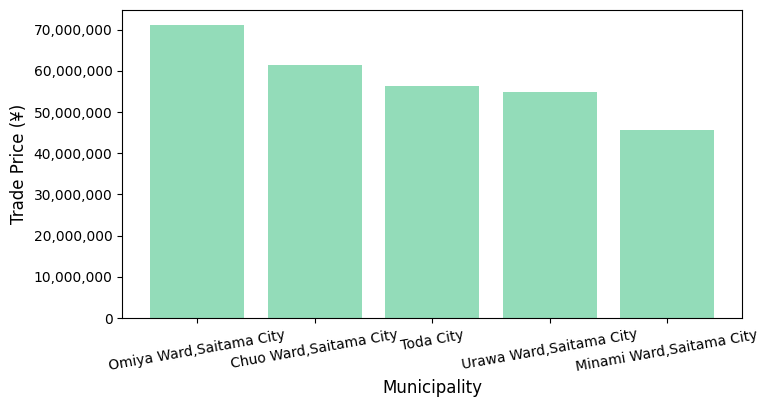

In [21]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(avg1_top5_max.keys(), avg1_top5_max.values(), color="#93DCB9")
ax.set_xlabel("Municipality", fontsize=12)
ax.set_ylabel("Trade Price (¥)", fontsize=12)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=10)
plt.show()

In [22]:
avg1_top5_max

{'Omiya Ward,Saitama City': 71215743,
 'Chuo Ward,Saitama City': 61434799,
 'Toda City': 56252718,
 'Urawa Ward,Saitama City': 54861677,
 'Minami Ward,Saitama City': 45616939}

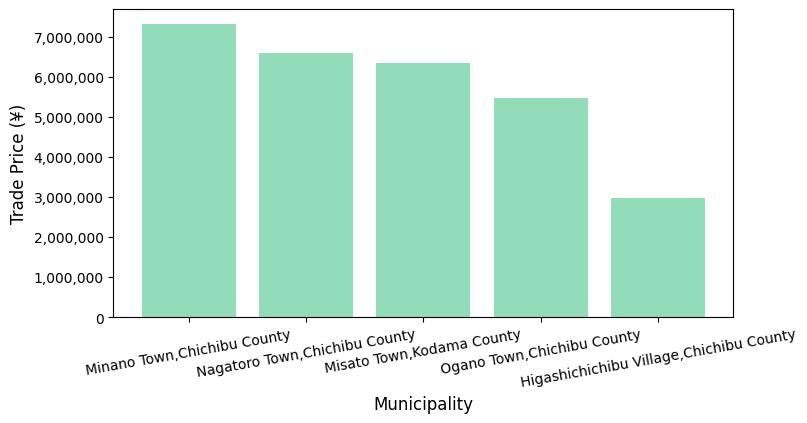

In [23]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(avg1_top5_min.keys(), avg1_top5_min.values(), color="#93DCB9")
ax.set_xlabel("Municipality", fontsize=12)
ax.set_ylabel("Trade Price (¥)", fontsize=12)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=10)
plt.show()

In [24]:
avg1_top5_min

{'Minano Town,Chichibu County': 7323520,
 'Nagatoro Town,Chichibu County': 6593889,
 'Misato Town,Kodama County': 6342091,
 'Ogano Town,Chichibu County': 5481824,
 'Higashichichibu Village,Chichibu County': 2989672}

<br>

<br>

In [25]:
# avg2 = average trade prices per municipality in Tokyo
avg2 = df_13.groupby('Municipality').agg(F.round(F.mean('TradePrice'), 0)).rdd.map(list).collect()
avg2_dict = list_to_dict(avg2)
avg2_top5_max = dict(list(avg2_dict.items())[0: 5]) 
avg2_top5_min = dict(list(avg2_dict.items())[-5:]) 

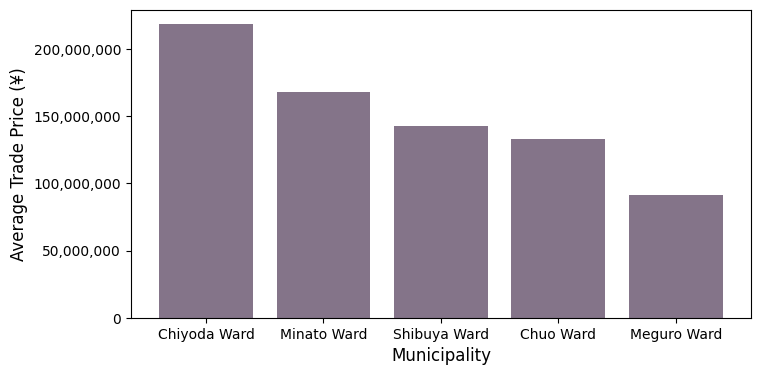

In [26]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(avg2_top5_max.keys(), avg2_top5_max.values(), color="#847489")
ax.set_xlabel("Municipality", fontsize=12)
ax.set_ylabel("Average Trade Price (¥)", fontsize=12)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=0)
plt.show()

In [27]:
avg2_top5_max

{'Chiyoda Ward': 218470851,
 'Minato Ward': 168276898,
 'Shibuya Ward': 142846076,
 'Chuo Ward': 133296637,
 'Meguro Ward': 91367119}

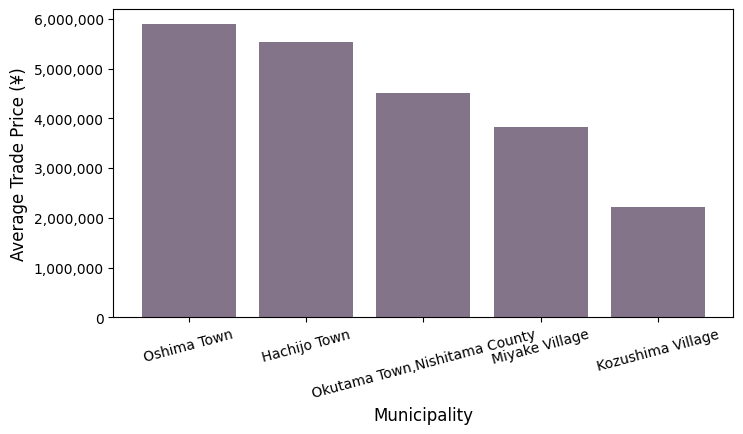

In [28]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(avg2_top5_min.keys(), avg2_top5_min.values(), color="#847489")
ax.set_xlabel("Municipality", fontsize=12)
ax.set_ylabel("Average Trade Price (¥)", fontsize=12)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=15)
plt.show()

In [29]:
avg2_top5_min

{'Oshima Town': 5897558,
 'Hachijo Town': 5526681,
 'Okutama Town,Nishitama County': 4501763,
 'Miyake Village': 3823804,
 'Kozushima Village': 2221211}

<br>

<br>

In [30]:
# avg3 = average trade prices per municipality in Kanagawa
avg3 = df_14.groupby('Municipality').agg(F.round(F.mean('TradePrice'), 0)).rdd.map(list).collect()
avg3_dict = list_to_dict(avg3)
avg3_top5_max = dict(list(avg3_dict.items())[0: 5]) 
avg3_top5_min = dict(list(avg3_dict.items())[-5:]) 

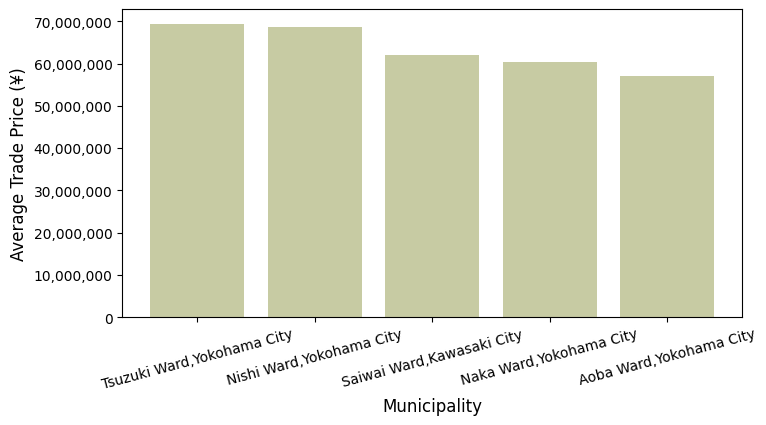

In [31]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(avg3_top5_max.keys(), avg3_top5_max.values(), color="#C7CBA3")
ax.set_xlabel("Municipality", fontsize=12)
ax.set_ylabel("Average Trade Price (¥)", fontsize=12)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=15)
plt.show()

In [32]:
avg3_top5_max

{'Tsuzuki Ward,Yokohama City': 69402411,
 'Nishi Ward,Yokohama City': 68537306,
 'Saiwai Ward,Kawasaki City': 61944208,
 'Naka Ward,Yokohama City': 60334958,
 'Aoba Ward,Yokohama City': 57036279}

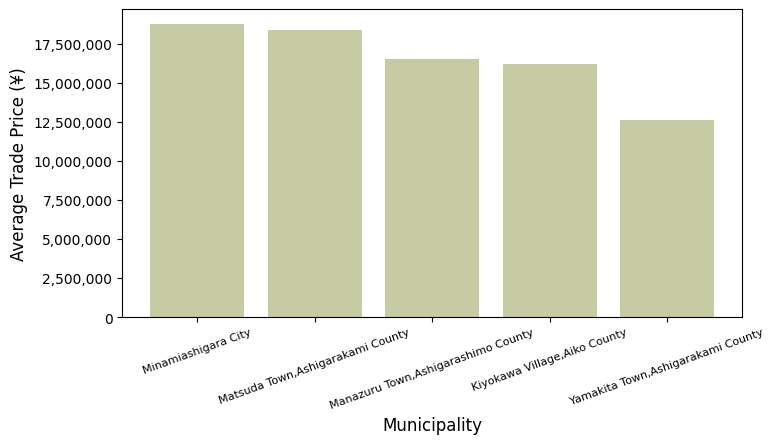

In [33]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(avg3_top5_min.keys(), avg3_top5_min.values(), color="#C7CBA3")
ax.set_xlabel("Municipality", fontsize=12)
ax.set_ylabel("Average Trade Price (¥)", fontsize=12)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=20, fontsize=8)
plt.show()

In [34]:
avg3_top5_min

{'Minamiashigara City': 18781421,
 'Matsuda Town,Ashigarakami County': 18404948,
 'Manazuru Town,Ashigarashimo County': 16531182,
 'Kiyokawa Village,Aiko County': 16194333,
 'Yamakita Town,Ashigarakami County': 12640906}

<br>

<br>

In [35]:
# avg4 = average trade prices per municipality in Osaka
avg4 = df_27.groupby('Municipality').agg(F.round(F.mean('TradePrice'), 0)).rdd.map(list).collect()
avg4_dict = list_to_dict(avg4)
avg4_top5_max = dict(list(avg4_dict.items())[0: 5]) 
avg4_top5_min = dict(list(avg4_dict.items())[-5:]) 

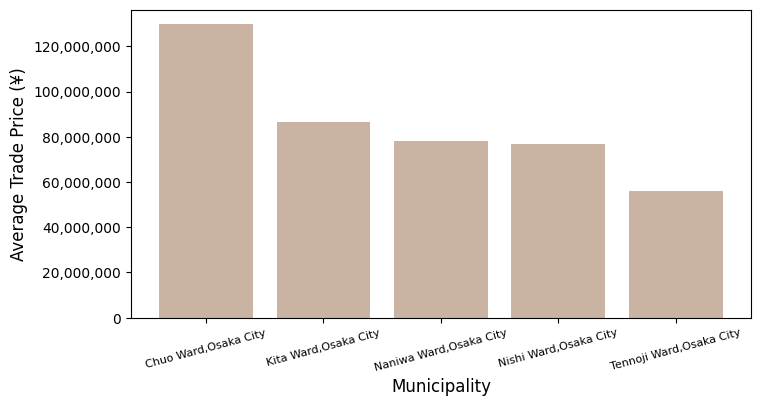

In [36]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(avg4_top5_max.keys(), avg4_top5_max.values(), color="#CBB3A3")
ax.set_xlabel("Municipality", fontsize=12)
ax.set_ylabel("Average Trade Price (¥)", fontsize=12)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=15, fontsize=8)
plt.show()

In [37]:
avg4_top5_max

{'Chuo Ward,Osaka City': 129739548,
 'Kita Ward,Osaka City': 86544371,
 'Naniwa Ward,Osaka City': 78006943,
 'Nishi Ward,Osaka City': 76724424,
 'Tennoji Ward,Osaka City': 56155008}

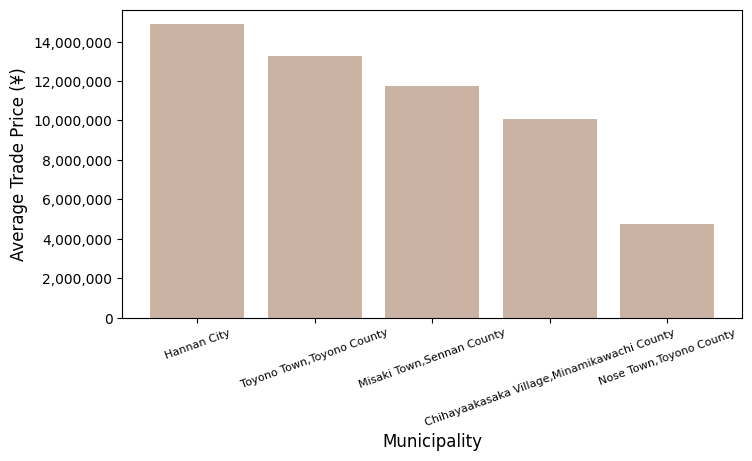

In [38]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(avg4_top5_min.keys(), avg4_top5_min.values(), color="#CBB3A3")
ax.set_xlabel("Municipality", fontsize=12)
ax.set_ylabel("Average Trade Price (¥)", fontsize=12)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=20, fontsize=8)
plt.show()

In [39]:
avg4_top5_min

{'Hannan City': 14880818,
 'Toyono Town,Toyono County': 13261956,
 'Misaki Town,Sennan County': 11738315,
 'Chihayaakasaka Village,Minamikawachi County': 10088762,
 'Nose Town,Toyono County': 4732515}

<br>

<br>

In [40]:
# avg5 = average trade prices per municipality in Fukuoka
avg5 = df_40.groupby('Municipality').agg(F.round(F.mean('TradePrice'), 0)).rdd.map(list).collect()
avg5_dict = list_to_dict(avg5)
avg5_top5_max = dict(list(avg5_dict.items())[0: 5]) 
avg5_top5_min = dict(list(avg5_dict.items())[-5:]) 

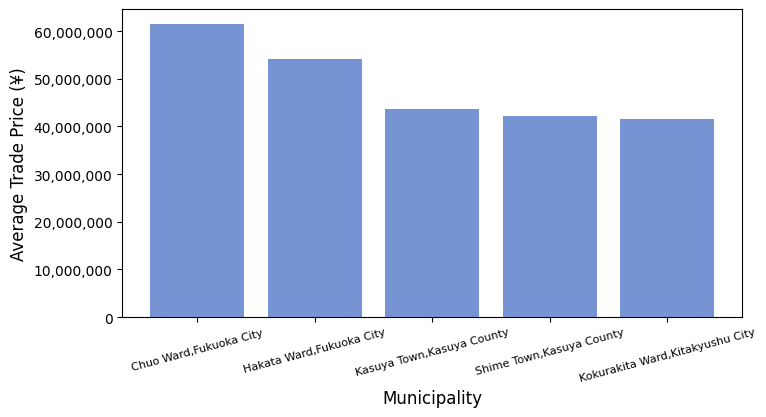

In [41]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(avg5_top5_max.keys(), avg5_top5_max.values(), color="#7693D4")
ax.set_xlabel("Municipality", fontsize=12)
ax.set_ylabel("Average Trade Price (¥)", fontsize=12)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=15, fontsize=8)
plt.show()

In [42]:
avg5_top5_max

{'Chuo Ward,Fukuoka City': 61555238,
 'Hakata Ward,Fukuoka City': 54213278,
 'Kasuya Town,Kasuya County': 43651183,
 'Shime Town,Kasuya County': 42199220,
 'Kokurakita Ward,Kitakyushu City': 41499039}

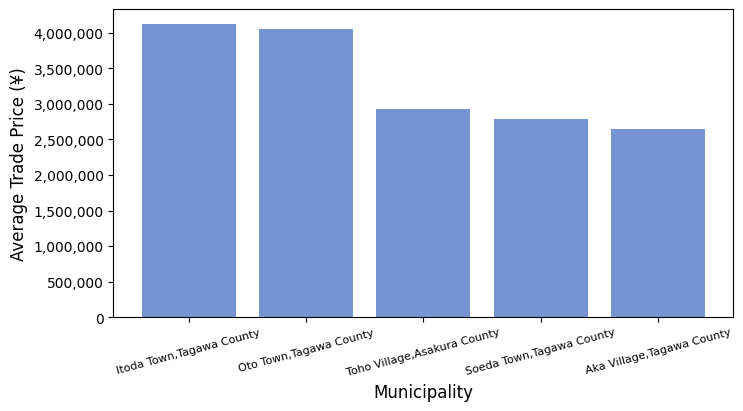

In [43]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(avg5_top5_min.keys(), avg5_top5_min.values(), color="#7693D4")
ax.set_xlabel("Municipality", fontsize=12)
ax.set_ylabel("Average Trade Price (¥)", fontsize=12)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xticks(rotation=15, fontsize=8)
plt.show()

In [44]:
avg5_top5_min

{'Itoda Town,Tagawa County': 4129084,
 'Oto Town,Tagawa County': 4052995,
 'Toho Village,Asakura County': 2933135,
 'Soeda Town,Tagawa County': 2787445,
 'Aka Village,Tagawa County': 2642154}

Analyzing average prices in each prefecture from 2005 - 2019

In [45]:
saitama = df_11.groupby('Year').agg(F.round(F.avg('TradePrice'), 0)).rdd.map(list).collect()
saitama_dict = list_to_dict_not_sorted(sorted(saitama))

tokyo = df_13.groupby('Year').agg(F.round(F.avg('TradePrice'), 0)).rdd.map(list).collect()
tokyo_dict = list_to_dict_not_sorted(sorted(tokyo))

kanagawa = df_14.groupby('Year').agg(F.round(F.avg('TradePrice'), 0)).rdd.map(list).collect()
kanagawa_dict = list_to_dict_not_sorted(sorted(kanagawa))

osaka = df_27.groupby('Year').agg(F.round(F.avg('TradePrice'), 0)).rdd.map(list).collect()
osaka_dict = list_to_dict_not_sorted(sorted(osaka))

fukuoka = df_40.groupby('Year').agg(F.round(F.avg('TradePrice'), 0)).rdd.map(list).collect()
fukuoka_dict = list_to_dict_not_sorted(sorted(fukuoka))

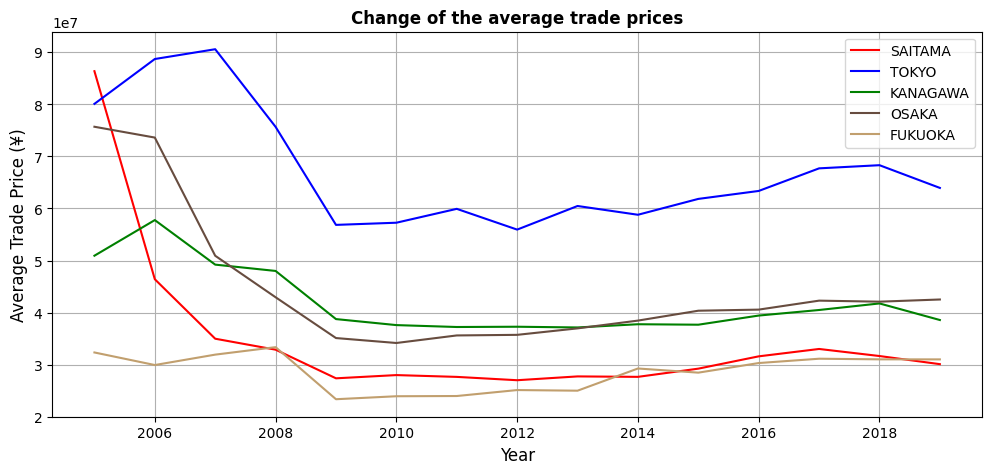

In [46]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(saitama_dict.keys(), saitama_dict.values(), color="r", label="SAITAMA")
ax.plot(tokyo_dict.keys(), tokyo_dict.values(), color="b", label="TOKYO")
ax.plot(kanagawa_dict.keys(), kanagawa_dict.values(), color="g", label="KANAGAWA")
ax.plot(osaka_dict.keys(), osaka_dict.values(), color="#674c3f", label="OSAKA")
ax.plot(fukuoka_dict.keys(), fukuoka_dict.values(), color="#c19f6e", label="FUKUOKA")
ax.grid(True)
ax.set_title("Change of the average trade prices", fontweight="bold")
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Average Trade Price (¥)", fontsize=12)

lines, handles = ax.get_legend_handles_labels()
ax.legend(lines, handles, loc="best")
plt.show()

### Tokyo Pre-Owned Condomiums Analysis

FloorPlan is available only for Pre-owned Condomium

In [47]:
df_13.filter(df_13.FloorPlan.isNotNull()).select('Type').distinct().show()

+--------------------+
|                Type|
+--------------------+
|Pre-owned Condomi...|
+--------------------+



There are 48 distinct FloorPlans of Pre-Owned Condomuims in Tokyo

In [48]:
df_13.filter(df_13.FloorPlan.isNotNull()).select('FloorPlan').distinct().count()

48

In [49]:
df_13.filter(df_13.FloorPlan.isNotNull()).select('FloorPlan').distinct().show()

+----------------+
|       FloorPlan|
+----------------+
|              1L|
|              3K|
|            3LDK|
|            2K+S|
|            1LDK|
|          5LDK+S|
|          1LDK+S|
|          4LDK+S|
|          3LDK+K|
|            7LDK|
|            2LDK|
|           1DK+S|
|            5LDK|
|              1K|
|      Open Floor|
|             3LK|
|              2K|
|          2LDK+S|
|          3LDK+S|
|Studio Apartment|
+----------------+
only showing top 20 rows



The most popular floor plans for pre-owned condomiums are 3LDK, 1K and 2LDK. 

In [50]:
df_13.filter(df_13.FloorPlan.isNotNull()).groupby('FloorPlan').count().show()

+----------------+-----+
|       FloorPlan|count|
+----------------+-----+
|              1L|    2|
|              3K|  113|
|            3LDK|49757|
|            2K+S|    7|
|            1LDK|14046|
|          5LDK+S|    4|
|          1LDK+S|  515|
|          4LDK+S|   23|
|          3LDK+K|    2|
|            7LDK|    2|
|            2LDK|31101|
|           1DK+S|   29|
|            5LDK|   88|
|              1K|49730|
|      Open Floor| 1641|
|             3LK|   16|
|              2K|  565|
|          2LDK+S| 1102|
|          3LDK+S|  137|
|Studio Apartment|   71|
+----------------+-----+
only showing top 20 rows



Average prices of each FloorPlan type in all municipalities

In [51]:
tokyo_prices_condomium_by_floor_plan = df_13.filter(df_13.FloorPlan.isNotNull()) \
                        .groupby('Year', 'Municipality', 'FloorPlan') \
                        .agg(F.round(F.avg('TradePrice'), 0)).rdd.map(list).collect()

In [52]:
tokyo_prices_condomium_by_floor_plan = sorted(tokyo_prices_condomium_by_floor_plan)

In [53]:
tokyo_prices_condomium_by_floor_plan

[[2005, 'Adachi Ward', '1DK', 4000000.0],
 [2005, 'Adachi Ward', '1K', 13078947.0],
 [2005, 'Adachi Ward', '1R', 11548000.0],
 [2005, 'Adachi Ward', '2DK', 11050000.0],
 [2005, 'Adachi Ward', '2K', 3500000.0],
 [2005, 'Adachi Ward', '2LDK', 17170000.0],
 [2005, 'Adachi Ward', '2LDK+S', 21000000.0],
 [2005, 'Adachi Ward', '2LK', 19000000.0],
 [2005, 'Adachi Ward', '3DK', 11280000.0],
 [2005, 'Adachi Ward', '3LDK', 19628235.0],
 [2005, 'Adachi Ward', '4LDK', 24500000.0],
 [2005, 'Adachi Ward', '5LDK', 13000000.0],
 [2005, 'Arakawa Ward', '1DK', 9325000.0],
 [2005, 'Arakawa Ward', '1K', 17752381.0],
 [2005, 'Arakawa Ward', '1LDK', 26000000.0],
 [2005, 'Arakawa Ward', '1R', 5300000.0],
 [2005, 'Arakawa Ward', '2DK', 16766667.0],
 [2005, 'Arakawa Ward', '2K', 8650000.0],
 [2005, 'Arakawa Ward', '2LDK', 20500000.0],
 [2005, 'Arakawa Ward', '2LDK+S', 21000000.0],
 [2005, 'Arakawa Ward', '3DK', 15000000.0],
 [2005, 'Arakawa Ward', '3LDK', 25250000.0],
 [2005, 'Arakawa Ward', '4LDK', 49000000.0

In [54]:
tokyo_prices_condomium_by_floor_plan[0][3]

4000000.0

Analysis of the prices for the most popular floor plan in Chuo Ward, Tokyo

In [55]:
dict_Chuo_3ldk = {}
for item in tokyo_prices_condomium_by_floor_plan:
    if item[1] == 'Chuo Ward' and item[2] == '3LDK':
        dict_Chuo_3ldk[item[0]] = int(item[3])

In [56]:
dict_Chuo_3ldk

{2005: 41000000,
 2006: 68560000,
 2007: 62562500,
 2008: 69281553,
 2009: 55116505,
 2010: 63634615,
 2011: 66295082,
 2012: 55607843,
 2013: 60709677,
 2014: 66064516,
 2015: 74800000,
 2016: 73235849,
 2017: 71009615,
 2018: 86913793,
 2019: 82000000}

In [57]:
dict_Chuo_1k = {}
for item in tokyo_prices_condomium_by_floor_plan:
    if item[1] == 'Chuo Ward' and item[2] == '2LDK':
        dict_Chuo_1k[item[0]] = int(item[3])

In [58]:
dict_Chuo_1k

{2005: 42687500,
 2006: 41826087,
 2007: 52060606,
 2008: 49483051,
 2009: 45922481,
 2010: 57271845,
 2011: 50765957,
 2012: 45464646,
 2013: 45928058,
 2014: 57457944,
 2015: 60553191,
 2016: 65038647,
 2017: 62968750,
 2018: 70439716,
 2019: 63428571}

In [59]:
dict_Chuo_2ldk = {}
for item in tokyo_prices_condomium_by_floor_plan:
    if item[1] == 'Chuo Ward' and item[2] == '1K':
        dict_Chuo_2ldk[item[0]] = int(item[3])

In [60]:
dict_Chuo_2ldk

{2005: 14332857,
 2006: 15964885,
 2007: 17294203,
 2008: 18623577,
 2009: 15305785,
 2010: 18346188,
 2011: 16364198,
 2012: 17342246,
 2013: 16923308,
 2014: 18684906,
 2015: 19293274,
 2016: 22783860,
 2017: 22393571,
 2018: 22782759,
 2019: 23175362}

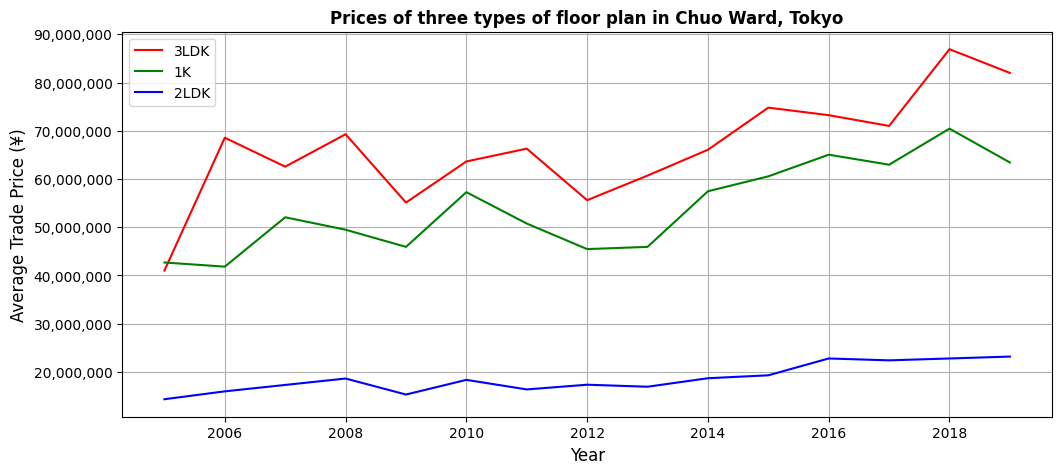

In [61]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(dict_Chuo_3ldk.keys(), dict_Chuo_3ldk.values(), color="r", label="3LDK")
ax.plot(dict_Chuo_1k.keys(), dict_Chuo_1k.values(), color="g", label="1K")
ax.plot(dict_Chuo_2ldk.keys(), dict_Chuo_2ldk.values(), color="b", label="2LDK")
ax.grid(True)
ax.set_title("Prices of three types of floor plan in Chuo Ward, Tokyo", fontweight="bold")
ax.set_xlabel("Year", fontsize=12)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel("Average Trade Price (¥)", fontsize=12)

lines, handles = ax.get_legend_handles_labels()
ax.legend(lines, handles, loc="best")
plt.show()

Tokyo: Average prices of real estates in different municipalities by regions for each year. 

In [62]:
tokyo_prices_by_region = df_13.filter(df_13.Region.isNotNull()) \
                        .groupby('Year', 'Region', 'Municipality') \
                        .agg(F.round(F.avg('TradePrice'), 0)).rdd.map(list).collect()

In [63]:
sorted(tokyo_prices_by_region)

[[2005, 'Commercial Area', 'Adachi Ward', 144455814.0],
 [2005, 'Commercial Area', 'Arakawa Ward', 88400000.0],
 [2005, 'Commercial Area', 'Bunkyo Ward', 141309677.0],
 [2005, 'Commercial Area', 'Chiyoda Ward', 700310345.0],
 [2005, 'Commercial Area', 'Chuo Ward', 423304878.0],
 [2005, 'Commercial Area', 'Edogawa Ward', 91402857.0],
 [2005, 'Commercial Area', 'Itabashi Ward', 68653846.0],
 [2005, 'Commercial Area', 'Katsushika Ward', 74403226.0],
 [2005, 'Commercial Area', 'Kita Ward', 160548148.0],
 [2005, 'Commercial Area', 'Koto Ward', 145350000.0],
 [2005, 'Commercial Area', 'Meguro Ward', 198920000.0],
 [2005, 'Commercial Area', 'Minato Ward', 517023256.0],
 [2005, 'Commercial Area', 'Nakano Ward', 217708333.0],
 [2005, 'Commercial Area', 'Nerima Ward', 211583871.0],
 [2005, 'Commercial Area', 'Ota Ward', 88354348.0],
 [2005, 'Commercial Area', 'Setagaya Ward', 125642857.0],
 [2005, 'Commercial Area', 'Shibuya Ward', 1088486486.0],
 [2005, 'Commercial Area', 'Shinagawa Ward', 2262

### Distribution Analysis

In this distribution analysis, we will see which features can show if Region is Residential, Industrial and etc.

In [64]:
df_11.select('Region').distinct().rdd.flatMap(list).collect()

['Industrial Area',
 None,
 'Residential Area',
 'Commercial Area',
 'Potential Residential Area']

In [65]:
df_11_residential = df_11.where(df_11.Region == 'Residential Area').select('Area').rdd.flatMap(list).collect()
df_11_residential_series = pd.Series(df_11_residential)

df_11_industrial = df_11.where(df_11.Region == 'Industrial Area').select('Area').rdd.flatMap(list).collect()
df_11_industrial_series = pd.Series(df_11_industrial)

df_11_commercial = df_11.where(df_11.Region == 'Commercial Area').select('Area').rdd.flatMap(list).collect()
df_11_commercial_series = pd.Series(df_11_commercial)

df_11_potential = df_11.where(df_11.Region == 'Potential Residential Area').select('Area').rdd.flatMap(list).collect()
df_11_potential_series = pd.Series(df_11_potential)

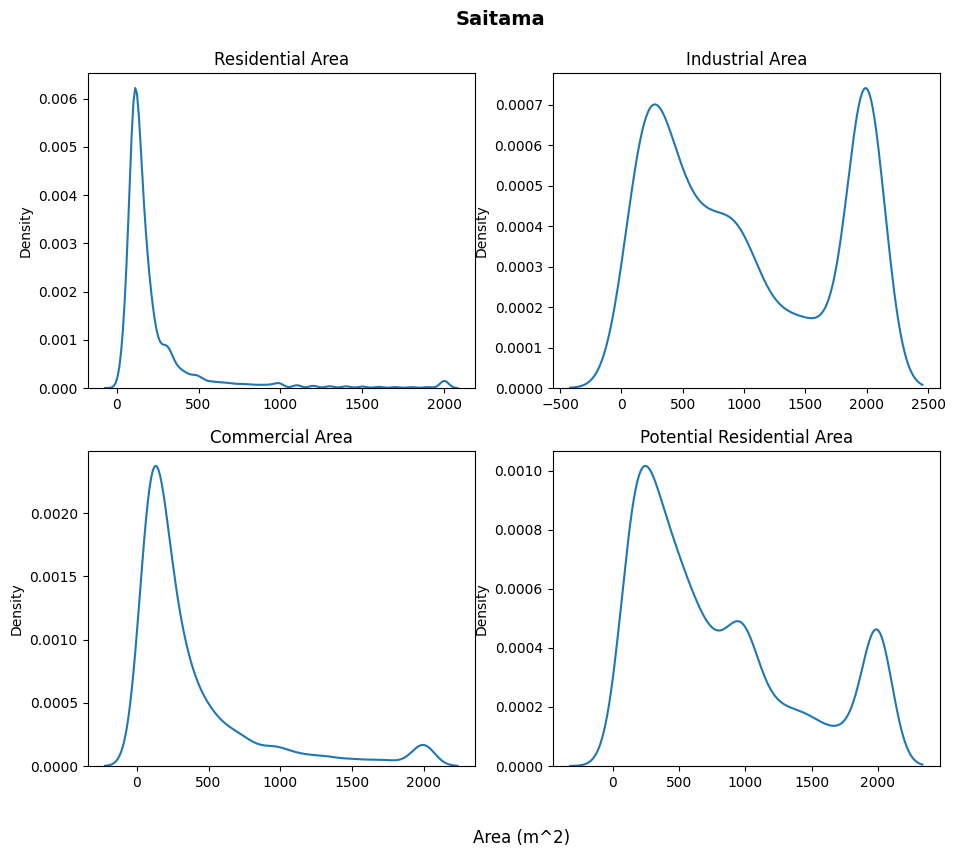

In [66]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[11, 9])

fig.suptitle("Saitama", x=0.5, y=0.95, fontsize=14, fontweight="bold")
fig.supxlabel("Area (m^2)", x=0.52, y=0.02, fontsize=12)

sns.kdeplot(data = df_11_residential_series, ax=axs[0, 0])
sns.kdeplot(data = df_11_industrial_series, ax=axs[0, 1])
sns.kdeplot(data = df_11_commercial_series, ax=axs[1, 0])
sns.kdeplot(data = df_11_potential_series, ax=axs[1, 1])

axs[0, 0].set_title("Residential Area")
axs[0, 1].set_title("Industrial Area")
axs[1, 0].set_title("Commercial Area")
axs[1, 1].set_title("Potential Residential Area")

plt.subplots_adjust(hspace = 0.2)
plt.show()

In [67]:
df_13_residential = df_13.where(df_13.Region == 'Residential Area').select('Area').rdd.flatMap(list).collect()
df_13_residential_series = pd.Series(df_13_residential)

df_13_industrial = df_13.where(df_13.Region == 'Industrial Area').select('Area').rdd.flatMap(list).collect()
df_13_industrial_series = pd.Series(df_13_industrial)

df_13_commercial = df_13.where(df_13.Region == 'Commercial Area').select('Area').rdd.flatMap(list).collect()
df_13_commercial_series = pd.Series(df_13_commercial)

df_13_potential = df_13.where(df_13.Region == 'Potential Residential Area').select('Area').rdd.flatMap(list).collect()
df_13_potential_series = pd.Series(df_13_potential)

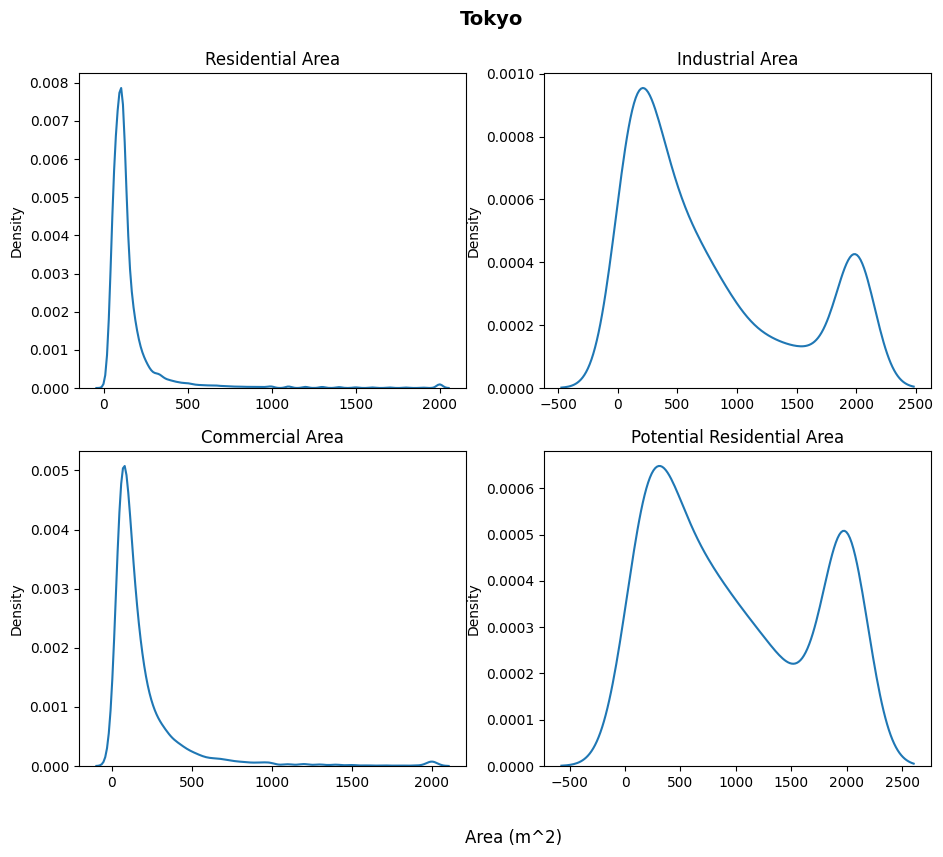

In [68]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[11, 9])

fig.suptitle("Tokyo", x=0.5, y=0.95, fontsize=14, fontweight="bold")
fig.supxlabel("Area (m^2)", x=0.52, y=0.02, fontsize=12)

sns.kdeplot(data = df_13_residential_series, ax=axs[0, 0])
sns.kdeplot(data = df_13_industrial_series, ax=axs[0, 1])
sns.kdeplot(data = df_13_commercial_series, ax=axs[1, 0])
sns.kdeplot(data = df_13_potential_series, ax=axs[1, 1])

axs[0, 0].set_title("Residential Area")
axs[0, 1].set_title("Industrial Area")
axs[1, 0].set_title("Commercial Area")
axs[1, 1].set_title("Potential Residential Area")

plt.subplots_adjust(hspace = 0.2)
plt.show()

In [69]:
df_14_residential = df_14.where(df_14.Region == 'Residential Area').select('Area').rdd.flatMap(list).collect()
df_14_residential_series = pd.Series(df_14_residential)

df_14_industrial = df_14.where(df_14.Region == 'Industrial Area').select('Area').rdd.flatMap(list).collect()
df_14_industrial_series = pd.Series(df_14_industrial)

df_14_commercial = df_14.where(df_14.Region == 'Commercial Area').select('Area').rdd.flatMap(list).collect()
df_14_commercial_series = pd.Series(df_14_commercial)

df_14_potential = df_14.where(df_14.Region == 'Potential Residential Area').select('Area').rdd.flatMap(list).collect()
df_14_potential_series = pd.Series(df_14_potential)

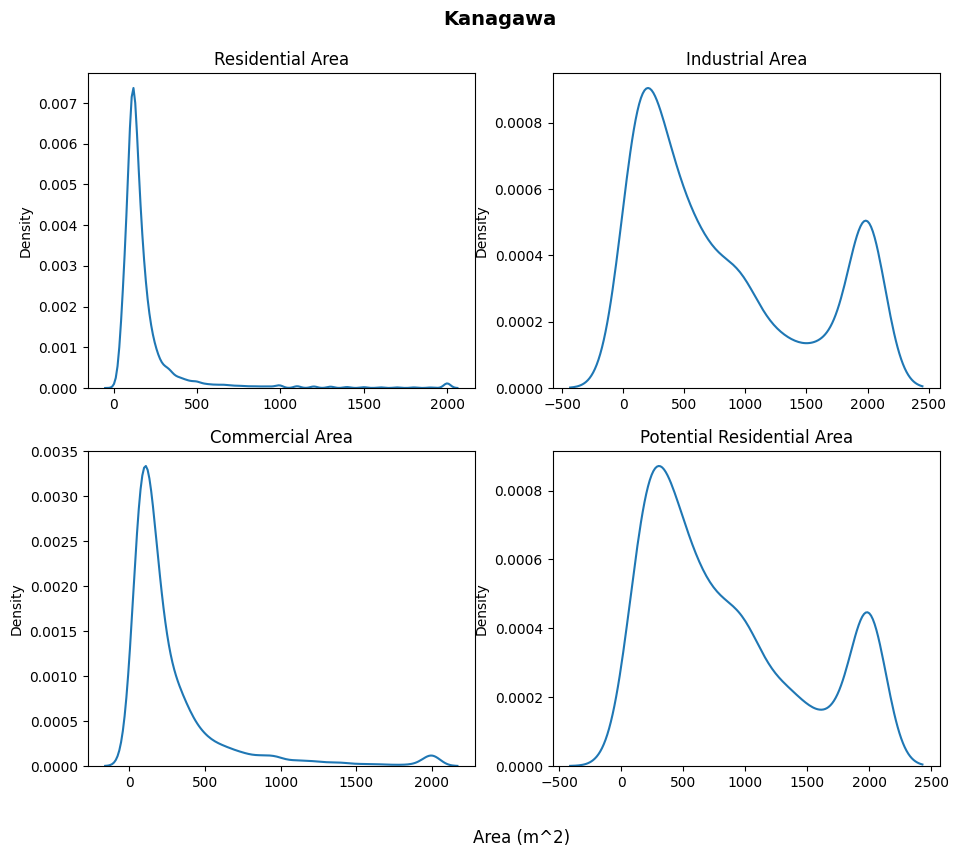

In [70]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[11, 9])

fig.suptitle("Kanagawa", x=0.5, y=0.95, fontsize=14, fontweight="bold")
fig.supxlabel("Area (m^2)", x=0.52, y=0.02, fontsize=12)

sns.kdeplot(data = df_14_residential_series, ax=axs[0, 0])
sns.kdeplot(data = df_14_industrial_series, ax=axs[0, 1])
sns.kdeplot(data = df_14_commercial_series, ax=axs[1, 0])
sns.kdeplot(data = df_14_potential_series, ax=axs[1, 1])

axs[0, 0].set_title("Residential Area")
axs[0, 1].set_title("Industrial Area")
axs[1, 0].set_title("Commercial Area")
axs[1, 1].set_title("Potential Residential Area")

plt.subplots_adjust(hspace = 0.2)
plt.show()

In [71]:
df_27_residential = df_27.where(df_27.Region == 'Residential Area').select('Area').rdd.flatMap(list).collect()
df_27_residential_series = pd.Series(df_27_residential)

df_27_industrial = df_27.where(df_27.Region == 'Industrial Area').select('Area').rdd.flatMap(list).collect()
df_27_industrial_series = pd.Series(df_27_industrial)

df_27_commercial = df_27.where(df_27.Region == 'Commercial Area').select('Area').rdd.flatMap(list).collect()
df_27_commercial_series = pd.Series(df_27_commercial)

df_27_potential = df_27.where(df_27.Region == 'Potential Residential Area').select('Area').rdd.flatMap(list).collect()
df_27_potential_series = pd.Series(df_27_potential)

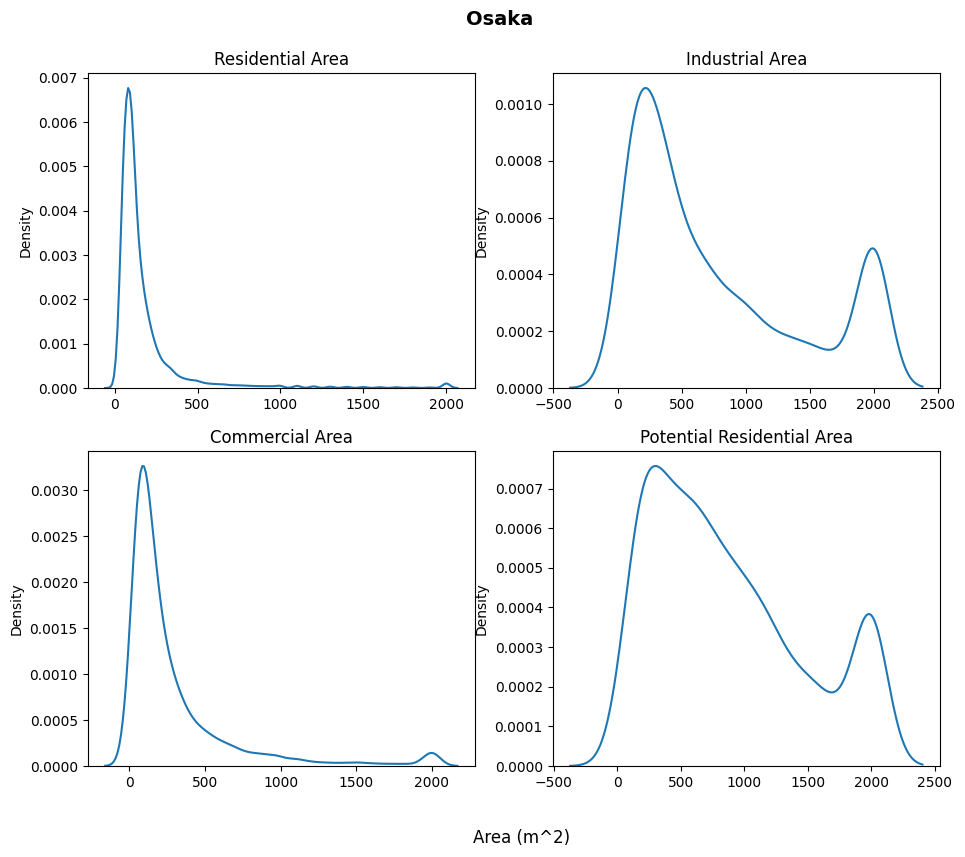

In [72]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[11, 9])

fig.suptitle("Osaka", x=0.5, y=0.95, fontsize=14, fontweight="bold")
fig.supxlabel("Area (m^2)", x=0.52, y=0.02, fontsize=12)

sns.kdeplot(data = df_27_residential_series, ax=axs[0, 0])
sns.kdeplot(data = df_27_industrial_series, ax=axs[0, 1])
sns.kdeplot(data = df_27_commercial_series, ax=axs[1, 0])
sns.kdeplot(data = df_27_potential_series, ax=axs[1, 1])

axs[0, 0].set_title("Residential Area")
axs[0, 1].set_title("Industrial Area")
axs[1, 0].set_title("Commercial Area")
axs[1, 1].set_title("Potential Residential Area")

plt.subplots_adjust(hspace = 0.2)
plt.show()

In [73]:
df_40_residential = df_40.where(df_40.Region == 'Residential Area').select('Area').rdd.flatMap(list).collect()
df_40_residential_series = pd.Series(df_40_residential)

df_40_industrial = df_40.where(df_40.Region == 'Industrial Area').select('Area').rdd.flatMap(list).collect()
df_40_industrial_series = pd.Series(df_40_industrial)

df_40_commercial = df_40.where(df_40.Region == 'Commercial Area').select('Area').rdd.flatMap(list).collect()
df_40_commercial_series = pd.Series(df_40_commercial)

df_40_potential = df_40.where(df_40.Region == 'Potential Residential Area').select('Area').rdd.flatMap(list).collect()
df_40_potential_series = pd.Series(df_40_potential)

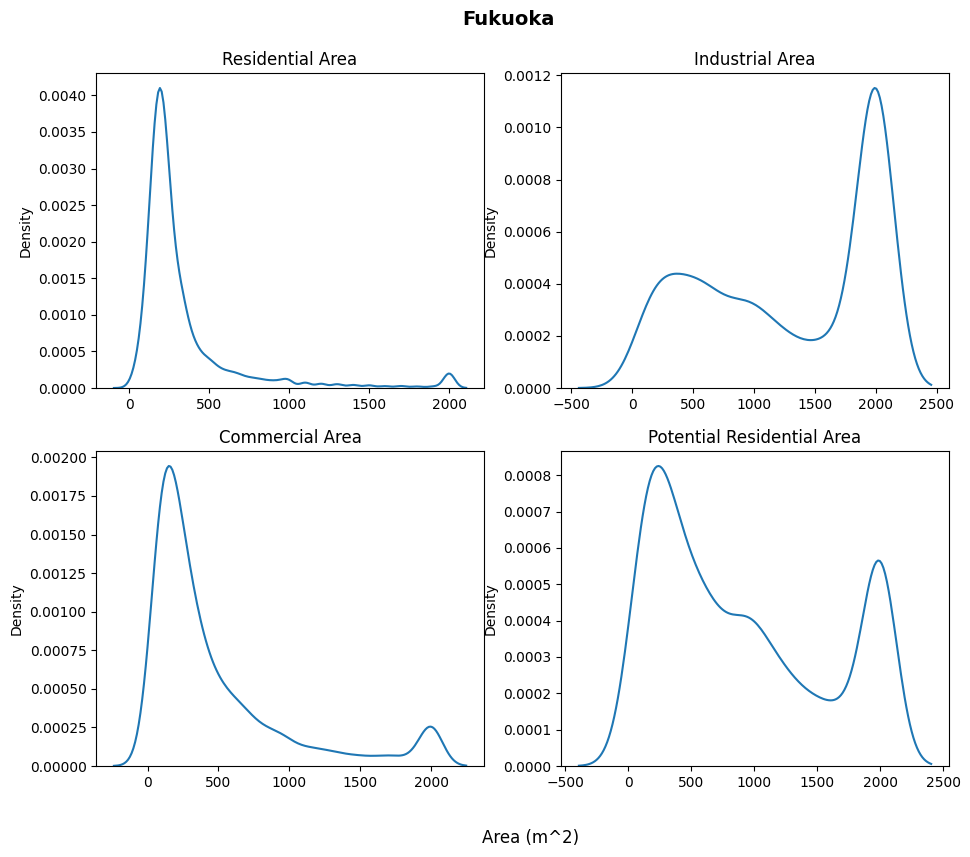

In [74]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[11, 9])

fig.suptitle("Fukuoka", x=0.5, y=0.95, fontsize=14, fontweight="bold")
fig.supxlabel("Area (m^2)", x=0.52, y=0.02, fontsize=12)

sns.kdeplot(data = df_40_residential_series, ax=axs[0, 0])
sns.kdeplot(data = df_40_industrial_series, ax=axs[0, 1])
sns.kdeplot(data = df_40_commercial_series, ax=axs[1, 0])
sns.kdeplot(data = df_40_potential_series, ax=axs[1, 1])

axs[0, 0].set_title("Residential Area")
axs[0, 1].set_title("Industrial Area")
axs[1, 0].set_title("Commercial Area")
axs[1, 1].set_title("Potential Residential Area")

plt.subplots_adjust(hspace = 0.2)
plt.show()

Distribution of MintimeToNearestStation for four types of region

In [75]:
df_11_residential_b = df_11.where((df_11.Region == 'Residential Area') & (df_11.MinTimeToNearestStation.isNotNull())).select('MinTimeToNearestStation').rdd.flatMap(list).collect()
df_11_residential_b_series = pd.Series(df_11_residential_b, dtype="int")

df_11_industrial_b = df_11.where((df_11.Region == 'Industrial Area') & (df_11.MinTimeToNearestStation.isNotNull())).select('MinTimeToNearestStation').rdd.flatMap(list).collect()
df_11_industrial_b_series = pd.Series(df_11_industrial_b, dtype="int")

df_11_commercial_b = df_11.where((df_11.Region == 'Commercial Area') & (df_11.MinTimeToNearestStation.isNotNull())).select('MinTimeToNearestStation').rdd.flatMap(list).collect()
df_11_commercial_b_series = pd.Series(df_11_commercial_b, dtype="int")

df_11_potential_b = df_11.where((df_11.Region == 'Potential Residential Area') & (df_11.MinTimeToNearestStation.isNotNull())).select('MinTimeToNearestStation').rdd.flatMap(list).collect()
df_11_potential_b_series = pd.Series(df_11_potential_b, dtype="int")

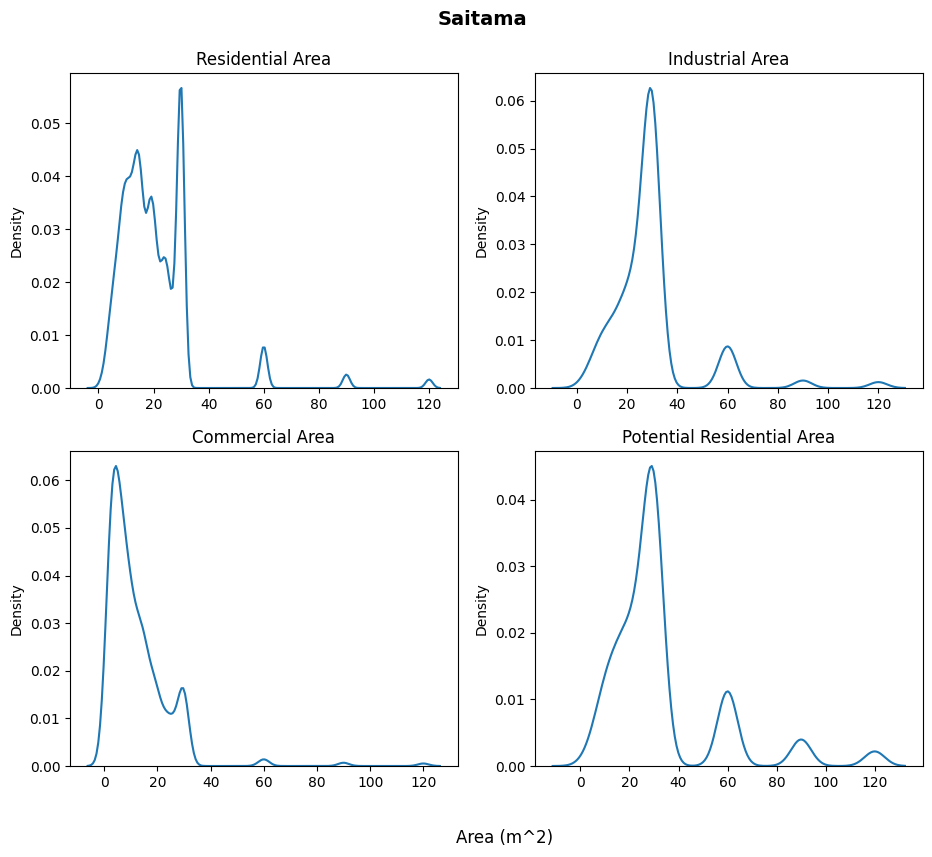

In [76]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[11, 9])

fig.suptitle("Saitama", x=0.5, y=0.95, fontsize=14, fontweight="bold")
fig.supxlabel("Area (m^2)", x=0.52, y=0.02, fontsize=12)

sns.kdeplot(data = df_11_residential_b_series, ax=axs[0, 0])
sns.kdeplot(data = df_11_industrial_b_series, ax=axs[0, 1])
sns.kdeplot(data = df_11_commercial_b_series, ax=axs[1, 0])
sns.kdeplot(data = df_11_potential_b_series, ax=axs[1, 1])

axs[0, 0].set_title("Residential Area")
axs[0, 1].set_title("Industrial Area")
axs[1, 0].set_title("Commercial Area")
axs[1, 1].set_title("Potential Residential Area")

plt.subplots_adjust(hspace = 0.2)
plt.show()

In [77]:
df_13_residential_b = df_13.where((df_13.Region == 'Residential Area') & (df_13.MinTimeToNearestStation.isNotNull())).select('MinTimeToNearestStation').rdd.flatMap(list).collect()
df_13_residential_b_series = pd.Series(df_13_residential_b, dtype="int")

df_13_industrial_b = df_13.where((df_13.Region == 'Industrial Area') & (df_13.MinTimeToNearestStation.isNotNull())).select('MinTimeToNearestStation').rdd.flatMap(list).collect()
df_13_industrial_b_series = pd.Series(df_13_industrial_b, dtype="int")

df_13_commercial_b = df_13.where((df_13.Region == 'Commercial Area') & (df_13.MinTimeToNearestStation.isNotNull())).select('MinTimeToNearestStation').rdd.flatMap(list).collect()
df_13_commercial_b_series = pd.Series(df_13_commercial_b, dtype="int")

df_13_potential_b = df_13.where((df_13.Region == 'Potential Residential Area') & (df_13.MinTimeToNearestStation.isNotNull())).select('MinTimeToNearestStation').rdd.flatMap(list).collect()
df_13_potential_b_series = pd.Series(df_13_potential_b, dtype="int")

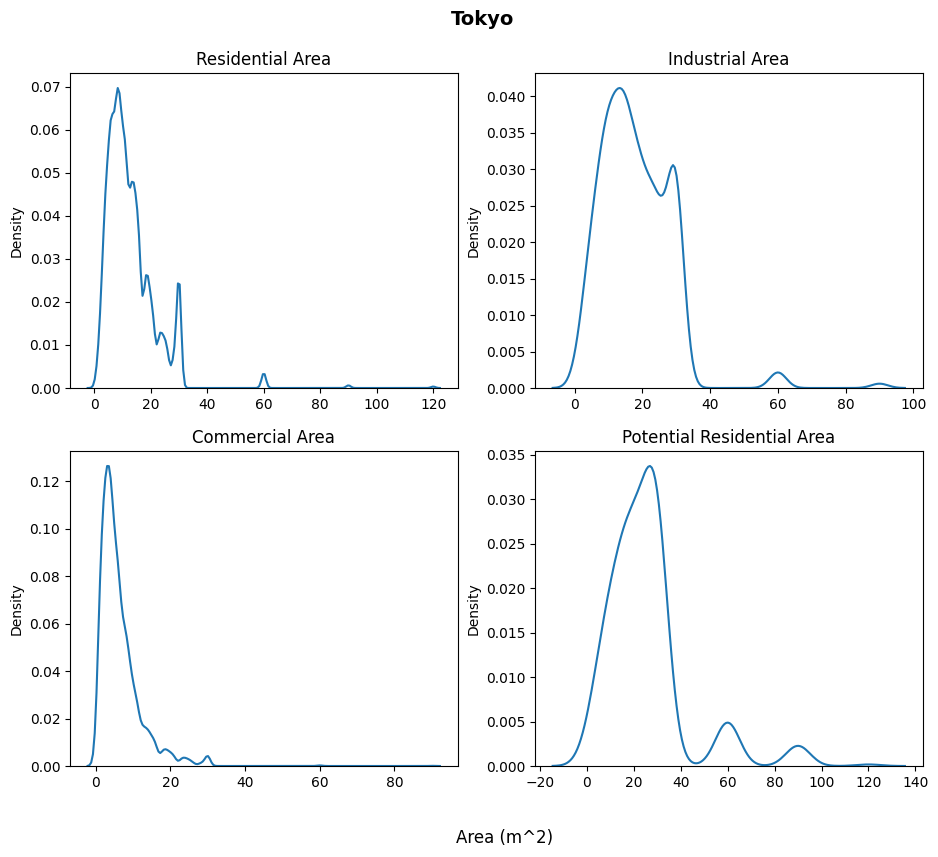

In [78]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[11, 9])

fig.suptitle("Tokyo", x=0.5, y=0.95, fontsize=14, fontweight="bold")
fig.supxlabel("Area (m^2)", x=0.52, y=0.02, fontsize=12)

sns.kdeplot(data = df_13_residential_b_series, ax=axs[0, 0])
sns.kdeplot(data = df_13_industrial_b_series, ax=axs[0, 1])
sns.kdeplot(data = df_13_commercial_b_series, ax=axs[1, 0])
sns.kdeplot(data = df_13_potential_b_series, ax=axs[1, 1])

axs[0, 0].set_title("Residential Area")
axs[0, 1].set_title("Industrial Area")
axs[1, 0].set_title("Commercial Area")
axs[1, 1].set_title("Potential Residential Area")

plt.subplots_adjust(hspace = 0.2)
plt.show()

In [79]:
df_14_residential_b = df_14.where((df_14.Region == 'Residential Area') & (df_14.MinTimeToNearestStation.isNotNull())).select('MinTimeToNearestStation').rdd.flatMap(list).collect()
df_14_residential_b_series = pd.Series(df_14_residential_b, dtype="int")

df_14_industrial_b = df_14.where((df_14.Region == 'Industrial Area') & (df_14.MinTimeToNearestStation.isNotNull())).select('MinTimeToNearestStation').rdd.flatMap(list).collect()
df_14_industrial_b_series = pd.Series(df_14_industrial_b, dtype="int")

df_14_commercial_b = df_14.where((df_14.Region == 'Commercial Area') & (df_14.MinTimeToNearestStation.isNotNull())).select('MinTimeToNearestStation').rdd.flatMap(list).collect()
df_14_commercial_b_series = pd.Series(df_14_commercial_b, dtype="int")

df_14_potential_b = df_14.where((df_14.Region == 'Potential Residential Area') & (df_14.MinTimeToNearestStation.isNotNull())).select('MinTimeToNearestStation').rdd.flatMap(list).collect()
df_14_potential_b_series = pd.Series(df_14_potential_b, dtype="int")

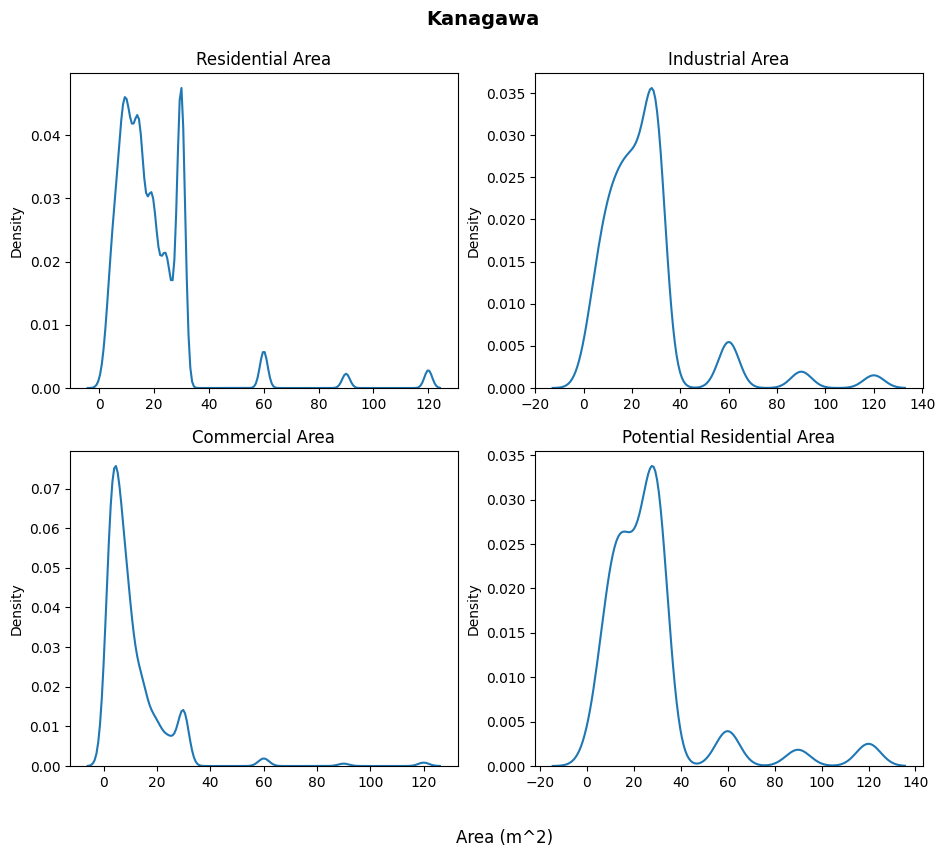

In [80]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[11, 9])

fig.suptitle("Kanagawa", x=0.5, y=0.95, fontsize=14, fontweight="bold")
fig.supxlabel("Area (m^2)", x=0.52, y=0.02, fontsize=12)

sns.kdeplot(data = df_14_residential_b_series, ax=axs[0, 0])
sns.kdeplot(data = df_14_industrial_b_series, ax=axs[0, 1])
sns.kdeplot(data = df_14_commercial_b_series, ax=axs[1, 0])
sns.kdeplot(data = df_14_potential_b_series, ax=axs[1, 1])

axs[0, 0].set_title("Residential Area")
axs[0, 1].set_title("Industrial Area")
axs[1, 0].set_title("Commercial Area")
axs[1, 1].set_title("Potential Residential Area")

plt.subplots_adjust(hspace = 0.2)
plt.show()

In [81]:
df_27_residential_b = df_27.where((df_27.Region == 'Residential Area') & (df_27.MinTimeToNearestStation.isNotNull())).select('MinTimeToNearestStation').rdd.flatMap(list).collect()
df_27_residential_b_series = pd.Series(df_27_residential_b, dtype="int")

df_27_industrial_b = df_27.where((df_27.Region == 'Industrial Area') & (df_27.MinTimeToNearestStation.isNotNull())).select('MinTimeToNearestStation').rdd.flatMap(list).collect()
df_27_industrial_b_series = pd.Series(df_27_industrial_b, dtype="int")

df_27_commercial_b = df_27.where((df_27.Region == 'Commercial Area') & (df_27.MinTimeToNearestStation.isNotNull())).select('MinTimeToNearestStation').rdd.flatMap(list).collect()
df_27_commercial_b_series = pd.Series(df_27_commercial_b, dtype="int")

df_27_potential_b = df_27.where((df_27.Region == 'Potential Residential Area') & (df_27.MinTimeToNearestStation.isNotNull())).select('MinTimeToNearestStation').rdd.flatMap(list).collect()
df_27_potential_b_series = pd.Series(df_27_potential_b, dtype="int")

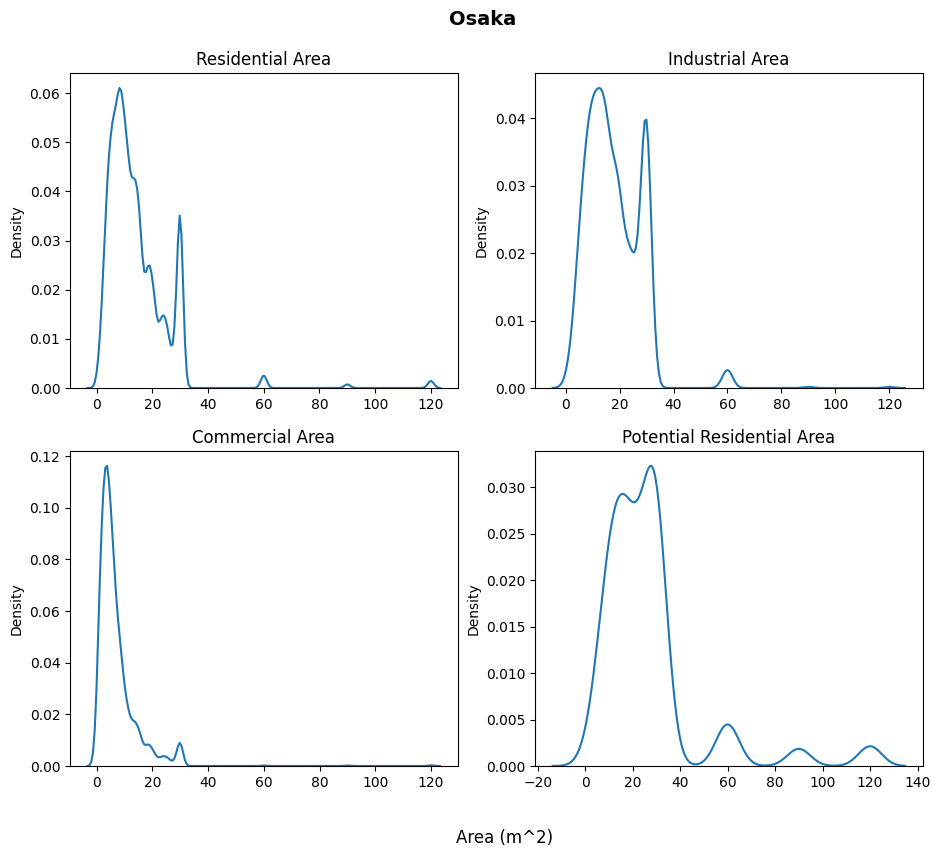

In [82]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[11, 9])

fig.suptitle("Osaka", x=0.5, y=0.95, fontsize=14, fontweight="bold")
fig.supxlabel("Area (m^2)", x=0.52, y=0.02, fontsize=12)

sns.kdeplot(data = df_27_residential_b_series, ax=axs[0, 0])
sns.kdeplot(data = df_27_industrial_b_series, ax=axs[0, 1])
sns.kdeplot(data = df_27_commercial_b_series, ax=axs[1, 0])
sns.kdeplot(data = df_27_potential_b_series, ax=axs[1, 1])

axs[0, 0].set_title("Residential Area")
axs[0, 1].set_title("Industrial Area")
axs[1, 0].set_title("Commercial Area")
axs[1, 1].set_title("Potential Residential Area")

plt.subplots_adjust(hspace = 0.2)
plt.show()

In [83]:
df_40_residential_b = df_40.where((df_40.Region == 'Residential Area') & (df_40.MinTimeToNearestStation.isNotNull())).select('MinTimeToNearestStation').rdd.flatMap(list).collect()
df_40_residential_b_series = pd.Series(df_40_residential_b, dtype="int")

df_40_industrial_b = df_40.where((df_40.Region == 'Industrial Area') & (df_40.MinTimeToNearestStation.isNotNull())).select('MinTimeToNearestStation').rdd.flatMap(list).collect()
df_40_industrial_b_series = pd.Series(df_40_industrial_b, dtype="int")

df_40_commercial_b = df_40.where((df_40.Region == 'Commercial Area') & (df_40.MinTimeToNearestStation.isNotNull())).select('MinTimeToNearestStation').rdd.flatMap(list).collect()
df_40_commercial_b_series = pd.Series(df_40_commercial_b, dtype="int")

df_40_potential_b = df_40.where((df_40.Region == 'Potential Residential Area') & (df_40.MinTimeToNearestStation.isNotNull())).select('MinTimeToNearestStation').rdd.flatMap(list).collect()
df_40_potential_b_series = pd.Series(df_40_potential_b, dtype="int")

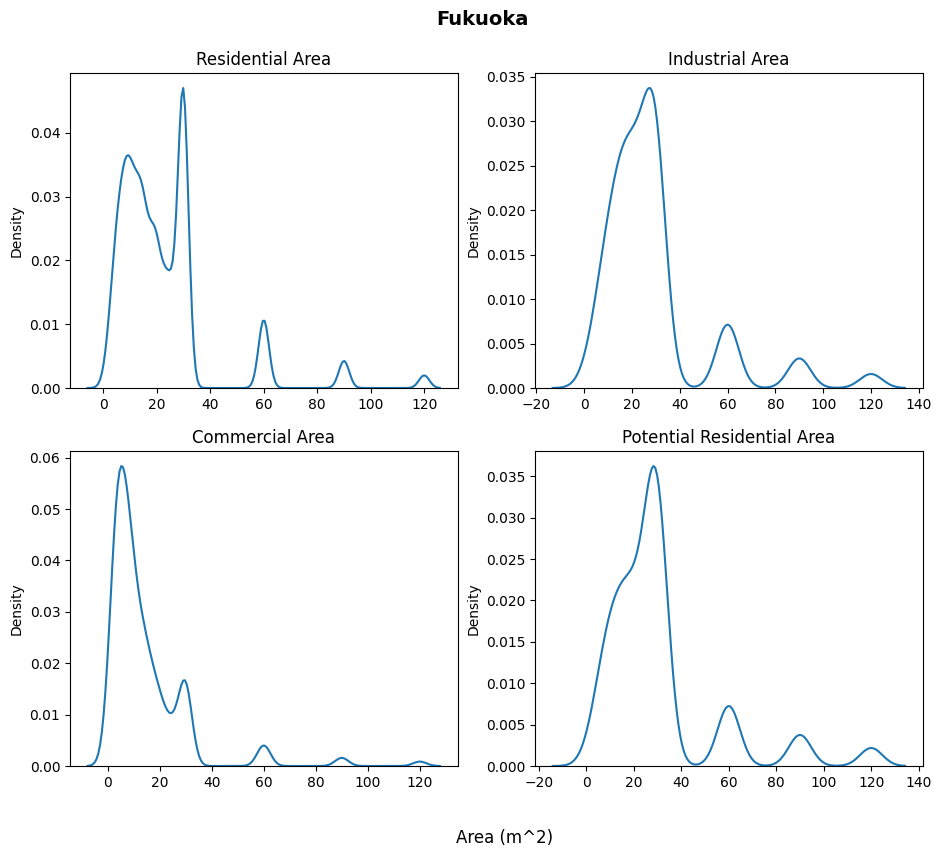

In [84]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[11, 9])

fig.suptitle("Fukuoka", x=0.5, y=0.95, fontsize=14, fontweight="bold")
fig.supxlabel("Area (m^2)", x=0.52, y=0.02, fontsize=12)

sns.kdeplot(data = df_40_residential_b_series, ax=axs[0, 0])
sns.kdeplot(data = df_40_industrial_b_series, ax=axs[0, 1])
sns.kdeplot(data = df_40_commercial_b_series, ax=axs[1, 0])
sns.kdeplot(data = df_40_potential_b_series, ax=axs[1, 1])

axs[0, 0].set_title("Residential Area")
axs[0, 1].set_title("Industrial Area")
axs[1, 0].set_title("Commercial Area")
axs[1, 1].set_title("Potential Residential Area")

plt.subplots_adjust(hspace = 0.2)
plt.show()

### Preprocessing for Correlation Analysis and ML Analysis

Correlation Analysis works only with numbers. Let's check which columns need to be removed. All DataFrames has same data types.

In [85]:
df_11.dtypes

[('No', 'int'),
 ('Type', 'string'),
 ('Region', 'string'),
 ('MunicipalityCode', 'int'),
 ('Prefecture', 'string'),
 ('Municipality', 'string'),
 ('DistrictName', 'string'),
 ('NearestStation', 'string'),
 ('TimeToNearestStation', 'string'),
 ('MinTimeToNearestStation', 'int'),
 ('MaxTimeToNearestStation', 'int'),
 ('TradePrice', 'bigint'),
 ('FloorPlan', 'string'),
 ('Area', 'int'),
 ('AreaIsGreaterFlag', 'int'),
 ('UnitPrice', 'double'),
 ('PricePerTsubo', 'double'),
 ('LandShape', 'string'),
 ('Frontage', 'double'),
 ('FrontageIsGreaterFlag', 'boolean'),
 ('TotalFloorArea', 'int'),
 ('TotalFloorAreaIsGreaterFlag', 'int'),
 ('BuildingYear', 'int'),
 ('PrewarBuilding', 'int'),
 ('Structure', 'string'),
 ('Use', 'string'),
 ('Purpose', 'string'),
 ('Direction', 'string'),
 ('Classification', 'string'),
 ('Breadth', 'double'),
 ('CityPlanning', 'string'),
 ('CoverageRatio', 'double'),
 ('FloorAreaRatio', 'double'),
 ('Period', 'string'),
 ('Year', 'int'),
 ('Quarter', 'int'),
 ('Renova

#### Checking count of null values

If the number of null values is big, we should remove that column. If not, we should just delete rows with null values.

In [86]:
print(df_11.filter(df_11.MinTimeToNearestStation.isNull()).count())
print(df_11.filter(df_11.MaxTimeToNearestStation.isNull()).count())
print(df_11.filter(df_11.TradePrice.isNull()).count())
print(df_11.filter(df_11.Area.isNull()).count())
print(df_11.filter(df_11.UnitPrice.isNull()).count())
print(df_11.filter(df_11.PricePerTsubo.isNull()).count())
print(df_11.filter(df_11.Frontage.isNull()).count())
print(df_11.filter(df_11.TotalFloorArea.isNull()).count())
print(df_11.filter(df_11.BuildingYear.isNull()).count())
print(df_11.filter(df_11.CoverageRatio.isNull()).count())
print(df_11.filter(df_11.FloorAreaRatio.isNull()).count())
print(df_11.filter(df_11.Year.isNull()).count())
print(df_11.filter(df_11.Quarter.isNull()).count())

5030
6029
0
0
137103
137103
57359
117071
81037
10901
10901
0
0


In [87]:
print(df_13.filter(df_13.MinTimeToNearestStation.isNull()).count())
print(df_13.filter(df_13.MaxTimeToNearestStation.isNull()).count())
print(df_13.filter(df_13.TradePrice.isNull()).count())
print(df_13.filter(df_13.Area.isNull()).count())
print(df_13.filter(df_13.UnitPrice.isNull()).count())
print(df_13.filter(df_13.PricePerTsubo.isNull()).count())
print(df_13.filter(df_13.Frontage.isNull()).count())
print(df_13.filter(df_13.TotalFloorArea.isNull()).count())
print(df_13.filter(df_13.BuildingYear.isNull()).count())
print(df_13.filter(df_13.CoverageRatio.isNull()).count())
print(df_13.filter(df_13.FloorAreaRatio.isNull()).count())
print(df_13.filter(df_13.Year.isNull()).count())
print(df_13.filter(df_13.Quarter.isNull()).count())

10339
10489
0
0
327072
327072
203688
270150
92279
5915
5915
0
0


In [88]:
print(df_14.filter(df_14.MinTimeToNearestStation.isNull()).count())
print(df_14.filter(df_14.MaxTimeToNearestStation.isNull()).count())
print(df_14.filter(df_14.TradePrice.isNull()).count())
print(df_14.filter(df_14.Area.isNull()).count())
print(df_14.filter(df_14.UnitPrice.isNull()).count())
print(df_14.filter(df_14.PricePerTsubo.isNull()).count())
print(df_14.filter(df_14.Frontage.isNull()).count())
print(df_14.filter(df_14.TotalFloorArea.isNull()).count())
print(df_14.filter(df_14.BuildingYear.isNull()).count())
print(df_14.filter(df_14.CoverageRatio.isNull()).count())
print(df_14.filter(df_14.FloorAreaRatio.isNull()).count())
print(df_14.filter(df_14.Year.isNull()).count())
print(df_14.filter(df_14.Quarter.isNull()).count())

6090
8064
0
0
207787
207787
107700
167922
83219
10796
10796
0
0


In [89]:
print(df_27.filter(df_27.MinTimeToNearestStation.isNull()).count())
print(df_27.filter(df_27.MaxTimeToNearestStation.isNull()).count())
print(df_27.filter(df_27.TradePrice.isNull()).count())
print(df_27.filter(df_27.Area.isNull()).count())
print(df_27.filter(df_27.UnitPrice.isNull()).count())
print(df_27.filter(df_27.PricePerTsubo.isNull()).count())
print(df_27.filter(df_27.Frontage.isNull()).count())
print(df_27.filter(df_27.TotalFloorArea.isNull()).count())
print(df_27.filter(df_27.BuildingYear.isNull()).count())
print(df_27.filter(df_27.CoverageRatio.isNull()).count())
print(df_27.filter(df_27.FloorAreaRatio.isNull()).count())
print(df_27.filter(df_27.Year.isNull()).count())
print(df_27.filter(df_27.Quarter.isNull()).count())

3240
3872
0
0
188675
188675
79442
120608
56610
4186
4186
0
0


In [90]:
print(df_40.filter(df_40.MinTimeToNearestStation.isNull()).count())
print(df_40.filter(df_40.MaxTimeToNearestStation.isNull()).count())
print(df_40.filter(df_40.TradePrice.isNull()).count())
print(df_40.filter(df_40.Area.isNull()).count())
print(df_40.filter(df_40.UnitPrice.isNull()).count())
print(df_40.filter(df_40.PricePerTsubo.isNull()).count())
print(df_40.filter(df_40.Frontage.isNull()).count())
print(df_40.filter(df_40.TotalFloorArea.isNull()).count())
print(df_40.filter(df_40.BuildingYear.isNull()).count())
print(df_40.filter(df_40.CoverageRatio.isNull()).count())
print(df_40.filter(df_40.FloorAreaRatio.isNull()).count())
print(df_40.filter(df_40.Year.isNull()).count())
print(df_40.filter(df_40.Quarter.isNull()).count())

10781
11792
0
0
89300
89300
45748
88715
62230
13878
13878
0
0


These columns shoud be removed.

In [91]:
columns_to_drop = ['No', 'Type', 'Region', 'Prefecture', 'Municipality', 'DistrictName', 'NearestStation', 'TimeToNearestStation', 
                   'FloorPlan', 'LandShape', 'Structure', 'Use', 'Purpose', 'Direction', 'Classification',
                  'CityPlanning', 'Period', 'Renovation', 'Remarks', 'UnitPrice', 'PricePerTsubo', 'Frontage', 'TotalFloorArea',
                  'BuildingYear']

df_11_upd = df_11.drop(*columns_to_drop)
df_13_upd = df_13.drop(*columns_to_drop)
df_14_upd = df_14.drop(*columns_to_drop)
df_27_upd = df_27.drop(*columns_to_drop)
df_40_upd = df_40.drop(*columns_to_drop)

Dropping the rows with null values.

In [92]:
df_11_upd = df_11_upd.na.drop()
df_13_upd = df_13_upd.na.drop()
df_14_upd = df_14_upd.na.drop()
df_27_upd = df_27_upd.na.drop()
df_40_upd = df_40_upd.na.drop()

In [93]:
columns = df_11_upd.columns

### Correlation Analysis

In [94]:
vector_col = 'features'

In [95]:
assembler_11 = VectorAssembler(inputCols=df_11_upd.columns, outputCol=vector_col)
assembler_13 = VectorAssembler(inputCols=df_13_upd.columns, outputCol=vector_col)
assembler_14 = VectorAssembler(inputCols=df_14_upd.columns, outputCol=vector_col)
assembler_27 = VectorAssembler(inputCols=df_27_upd.columns, outputCol=vector_col)
assembler_40 = VectorAssembler(inputCols=df_40_upd.columns, outputCol=vector_col)

In [96]:
df_11_vector = assembler_11.transform(df_11_upd).select(vector_col)
df_13_vector = assembler_13.transform(df_13_upd).select(vector_col)
df_14_vector = assembler_14.transform(df_14_upd).select(vector_col)
df_27_vector = assembler_27.transform(df_27_upd).select(vector_col)
df_40_vector = assembler_40.transform(df_40_upd).select(vector_col)

In [97]:
matrix_11 = Correlation.corr(df_11_vector, vector_col, 'pearson').collect()[0][0]
matrix_13 = Correlation.corr(df_13_vector, vector_col, 'pearson').collect()[0][0]
matrix_14 = Correlation.corr(df_14_vector, vector_col, 'pearson').collect()[0][0]
matrix_27 = Correlation.corr(df_27_vector, vector_col, 'pearson').collect()[0][0]
matrix_40 = Correlation.corr(df_40_vector, vector_col, 'pearson').collect()[0][0]

In [98]:
corrmatrix_11 = matrix_11.toArray().tolist()
corrmatrix_13 = matrix_13.toArray().tolist()
corrmatrix_14 = matrix_14.toArray().tolist()
corrmatrix_27 = matrix_27.toArray().tolist()
corrmatrix_40 = matrix_40.toArray().tolist()

In [99]:
df_11_corr = spark.createDataFrame(corrmatrix_11, columns)
df_13_corr = spark.createDataFrame(corrmatrix_13, columns)
df_14_corr = spark.createDataFrame(corrmatrix_14, columns)
df_27_corr = spark.createDataFrame(corrmatrix_27, columns)
df_40_corr = spark.createDataFrame(corrmatrix_40, columns)

In [100]:
df_11_corr_pd = pd.DataFrame(corrmatrix_11, columns=columns)
df_13_corr_pd = pd.DataFrame(corrmatrix_13, columns=columns)
df_14_corr_pd = pd.DataFrame(corrmatrix_14, columns=columns)
df_27_corr_pd = pd.DataFrame(corrmatrix_27, columns=columns)
df_40_corr_pd = pd.DataFrame(corrmatrix_40, columns=columns)

Visualization of Pearson Correlation

### Saitama

In [101]:
df_11_corr_pd.style.background_gradient(cmap='Blues')

,MunicipalityCode,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,AreaIsGreaterFlag,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,Breadth,CoverageRatio,FloorAreaRatio,Year,Quarter
0,1.000000,0.120319,0.107418,-0.046460,0.106240,0.044196,0.043915,-0.006759,0.003877,0.017049,-0.030341,-0.070387,0.037834,0.002903
1,0.120319,1.000000,0.919907,-0.041327,0.152843,0.083691,0.071890,0.009065,0.002441,-0.019655,-0.161470,-0.126455,-0.030969,0.005962
2,0.107418,0.919907,1.000000,-0.037132,0.167159,0.090906,0.077457,0.013856,0.004013,-0.010463,-0.127729,-0.094596,-0.035068,0.005308
3,-0.046460,-0.041327,-0.037132,1.000000,0.205985,0.207340,0.162936,0.228707,0.001423,0.096124,0.063720,0.072075,-0.009010,-0.003501
4,0.106240,0.152843,0.167159,0.205985,1.000000,0.665583,0.442852,0.224164,0.000718,0.165639,0.034925,0.050765,-0.004424,-0.004950
5,0.044196,0.083691,0.090906,0.207340,0.665583,1.000000,0.463965,0.252753,0.001450,0.087301,0.006884,0.018667,-0.004554,-0.004478
6,0.043915,0.071890,0.077457,0.162936,0.442852,0.463965,1.000000,0.182556,-0.000489,0.081718,0.010326,0.018634,-0.005117,-0.007995
7,-0.006759,0.009065,0.013856,0.228707,0.224164,0.252753,0.182556,1.000000,0.004125,0.076922,0.038172,0.046278,-0.003906,-0.002414
8,0.003877,0.002441,0.004013,0.001423,0.000718,0.001450,-0.000489,0.004125,1.000000,0.001224,0.006201,0.002290,-0.011490,-0.001423
9,0.017049,-0.019655,-0.010463,0.096124,0.165639,0.087301,0.081718,0.076922,0.001224,1.000000,0.127558,0.116645,0.013650,-0.001955


### Tokyo

In [102]:
df_13_corr_pd.style.background_gradient(cmap='Blues')

,MunicipalityCode,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,AreaIsGreaterFlag,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,Breadth,CoverageRatio,FloorAreaRatio,Year,Quarter
0,1.000000,0.387004,0.338205,-0.092358,0.098469,0.025775,0.027279,-0.041302,-0.008043,-0.043478,-0.522600,-0.453107,0.092131,-0.008240
1,0.387004,1.000000,0.924500,-0.089791,0.065085,0.029193,0.019141,-0.042380,-0.006221,-0.054039,-0.402643,-0.376591,0.002264,0.005717
2,0.338205,0.924500,1.000000,-0.071325,0.069563,0.030385,0.019882,-0.031258,-0.005207,-0.038073,-0.339493,-0.305446,-0.006857,0.005255
3,-0.092358,-0.089791,-0.071325,1.000000,0.372361,0.317106,0.235534,0.402879,0.003835,0.203417,0.127795,0.201099,-0.016546,-0.009016
4,0.098469,0.065085,0.069563,0.372361,1.000000,0.611056,0.438174,0.293355,0.004345,0.185356,-0.028900,-0.004364,-0.013700,-0.011677
5,0.025775,0.029193,0.030385,0.317106,0.611056,1.000000,0.501515,0.195697,0.002449,0.082439,-0.006591,-0.000067,-0.010274,-0.008259
6,0.027279,0.019141,0.019882,0.235534,0.438174,0.501515,1.000000,0.159169,0.000445,0.071537,-0.002381,0.000061,-0.008740,-0.009658
7,-0.041302,-0.042380,-0.031258,0.402879,0.293355,0.195697,0.159169,1.000000,0.004645,0.170210,0.089114,0.143444,-0.014024,-0.005201
8,-0.008043,-0.006221,-0.005207,0.003835,0.004345,0.002449,0.000445,0.004645,1.000000,0.002065,0.009255,0.013005,-0.005859,-0.001961
9,-0.043478,-0.054039,-0.038073,0.203417,0.185356,0.082439,0.071537,0.170210,0.002065,1.000000,0.292590,0.388293,-0.017438,-0.005494


### Kanagawa

In [103]:
df_14_corr_pd.style.background_gradient(cmap='Blues')

,MunicipalityCode,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,AreaIsGreaterFlag,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,Breadth,CoverageRatio,FloorAreaRatio,Year,Quarter
0,1.000000,0.185545,0.188097,-0.044851,0.110140,0.038459,0.037019,0.000275,0.000549,-0.039213,0.077962,0.098883,0.076960,-0.002664
1,0.185545,1.000000,0.924225,-0.048789,0.088120,0.041402,0.043274,-0.011599,-0.002214,-0.021486,-0.155839,-0.146009,-0.006438,0.000476
2,0.188097,0.924225,1.000000,-0.041603,0.090038,0.042655,0.042975,-0.006947,-0.002781,-0.010998,-0.126878,-0.110129,-0.010010,0.000105
3,-0.044851,-0.048789,-0.041603,1.000000,0.324032,0.337663,0.259396,0.260882,0.004746,0.148394,0.061688,0.110091,-0.021337,-0.009930
4,0.110140,0.088120,0.090038,0.324032,1.000000,0.644753,0.467812,0.252702,0.004108,0.160161,-0.031911,-0.001583,-0.016086,-0.010733
5,0.038459,0.041402,0.042655,0.337663,0.644753,1.000000,0.493098,0.263401,0.006304,0.090325,0.004032,0.013894,-0.016306,-0.007596
6,0.037019,0.043274,0.042975,0.259396,0.467812,0.493098,1.000000,0.175816,-0.000424,0.088206,0.007956,0.016579,-0.010069,-0.009718
7,0.000275,-0.011599,-0.006947,0.260882,0.252702,0.263401,0.175816,1.000000,0.009965,0.113989,0.064887,0.109917,-0.001507,-0.008465
8,0.000549,-0.002214,-0.002781,0.004746,0.004108,0.006304,-0.000424,0.009965,1.000000,0.005648,0.008936,0.011113,-0.006175,-0.000759
9,-0.039213,-0.021486,-0.010998,0.148394,0.160161,0.090325,0.088206,0.113989,0.005648,1.000000,0.183554,0.248163,-0.009426,-0.005504


### Osaka

In [104]:
df_27_corr_pd.style.background_gradient(cmap='Blues')

,MunicipalityCode,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,AreaIsGreaterFlag,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,Breadth,CoverageRatio,FloorAreaRatio,Year,Quarter
0,1.000000,0.334612,0.283303,-0.079232,0.068026,0.017475,0.016501,-0.048419,-0.020785,-0.142862,-0.552668,-0.392328,0.077115,-0.012128
1,0.334612,1.000000,0.920958,-0.064064,0.072177,0.039562,0.031234,-0.031697,-0.011491,-0.048614,-0.396752,-0.354765,0.004960,-0.008453
2,0.283303,0.920958,1.000000,-0.046380,0.073645,0.039579,0.032711,-0.022358,-0.008661,-0.027326,-0.333971,-0.296858,0.001430,-0.007047
3,-0.079232,-0.064064,-0.046380,1.000000,0.370040,0.335180,0.259039,0.373418,-0.001067,0.209772,0.099204,0.225503,-0.012926,-0.007237
4,0.068026,0.072177,0.073645,0.370040,1.000000,0.638565,0.459641,0.314179,-0.003846,0.209688,-0.055393,0.005520,0.015041,-0.016901
5,0.017475,0.039562,0.039579,0.335180,0.638565,1.000000,0.503738,0.249763,-0.000757,0.114875,-0.015506,0.003838,-0.003540,-0.016303
6,0.016501,0.031234,0.032711,0.259039,0.459641,0.503738,1.000000,0.187335,-0.000210,0.108830,-0.009453,0.005675,-0.001560,-0.010897
7,-0.048419,-0.031697,-0.022358,0.373418,0.314179,0.249763,0.187335,1.000000,0.000540,0.161595,0.070531,0.159013,-0.005245,-0.005544
8,-0.020785,-0.011491,-0.008661,-0.001067,-0.003846,-0.000757,-0.000210,0.000540,1.000000,-0.003351,0.025071,0.014163,0.011894,0.004953
9,-0.142862,-0.048614,-0.027326,0.209772,0.209688,0.114875,0.108830,0.161595,-0.003351,1.000000,0.180161,0.327381,-0.020433,-0.007316


### Fukuoka

In [105]:
df_40_corr_pd.style.background_gradient(cmap='Blues')

,MunicipalityCode,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,AreaIsGreaterFlag,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,Breadth,CoverageRatio,FloorAreaRatio,Year,Quarter
0,1.000000,0.092061,0.086693,-0.076053,0.109013,0.050771,0.060899,-0.025804,-0.003181,-0.052807,0.025295,-0.023646,0.016418,-0.001753
1,0.092061,1.000000,0.941252,-0.078565,0.097103,0.063081,0.049356,-0.025067,0.003193,-0.045688,-0.124172,-0.186392,-0.026160,0.007310
2,0.086693,0.941252,1.000000,-0.074004,0.095244,0.061724,0.052050,-0.023557,0.002788,-0.042471,-0.130049,-0.184958,-0.027749,0.006870
3,-0.076053,-0.078565,-0.074004,1.000000,0.272687,0.249123,0.202037,0.364146,0.002091,0.228776,0.123754,0.200978,0.008744,-0.003946
4,0.109013,0.097103,0.095244,0.272687,1.000000,0.719125,0.512088,0.206184,0.002487,0.193961,0.080302,0.060653,0.016396,-0.006323
5,0.050771,0.063081,0.061724,0.249123,0.719125,1.000000,0.532040,0.175578,0.002710,0.145688,0.043808,0.037345,0.001503,-0.005276
6,0.060899,0.049356,0.052050,0.202037,0.512088,0.532040,1.000000,0.128918,0.000219,0.133023,0.039039,0.032165,0.002784,-0.009097
7,-0.025804,-0.025067,-0.023557,0.364146,0.206184,0.175578,0.128918,1.000000,0.010220,0.136999,0.085893,0.124462,0.000332,-0.004819
8,-0.003181,0.003193,0.002788,0.002091,0.002487,0.002710,0.000219,0.010220,1.000000,-0.006115,0.015247,0.015866,0.003935,0.002318
9,-0.052807,-0.045688,-0.042471,0.228776,0.193961,0.145688,0.133023,0.136999,-0.006115,1.000000,0.203925,0.271891,-0.014143,-0.008697


# ML Analysis

In [106]:
columns_ml = ['MunicipalityCode', 'MinTimeToNearestStation', 'MaxTimeToNearestStation', 'Area', 'AreaIsGreaterFlag',
              'FrontageIsGreaterFlag', 'TotalFloorAreaIsGreaterFlag', 'PrewarBuilding', 'Breadth', 'CoverageRatio', 
              'FloorAreaRatio', 'Year']

In [107]:
assembler_ml = VectorAssembler(inputCols=columns_ml, outputCol=vector_col)

### Saitama

In [120]:
df_11_ml = assembler_ml.transform(df_11_upd)

In [121]:
df_11_ml = df_11_ml.select(['features', 'TradePrice'])

In [122]:
splits_11 = df_11_ml.randomSplit([0.8, 0.2])
train_df_11 = splits_11[0]
test_df_11 = splits_11[1]

In [123]:
lr_11 = LinearRegression(featuresCol = 'features', labelCol='TradePrice', maxIter=100, regParam=0.3, elasticNetParam=0.8)

lr_model_11 = lr_11.fit(train_df_11)

print("Coefficients: " + str(lr_model_11.coefficients))
print("Intercept: " + str(lr_model_11.intercept))

Coefficients: [-138306.88639227542,-308855.0733242127,-266796.4894535424,48163.823953929095,96120644.57951556,81549377.73219232,531314802.3747945,4923325.376051757,2249833.8457327764,353997.16719998035,107095.80955120035,-417326.877026317]
Intercept: 2366794237.414844


In [124]:
trainingSummary_11 = lr_model_11.summary
print("RMSE: %f" % trainingSummary_11.rootMeanSquaredError)
print("r2: %f" % trainingSummary_11.r2)

RMSE: 168150038.130277
r2: 0.086296


In [125]:
train_df_11.describe().show()

+-------+--------------------+
|summary|          TradePrice|
+-------+--------------------+
|  count|              125100|
|   mean| 3.425656919064748E7|
| stddev|1.7591218622368225E8|
|    min|                 450|
|    max|         47000000000|
+-------+--------------------+



In [126]:
lr_predictions_11 = lr_model_11.transform(test_df_11)
lr_predictions_11.select("prediction","TradePrice","features").show(10)

+--------------------+----------+--------------------+
|          prediction|TradePrice|            features|
+--------------------+----------+--------------------+
| 4.471945672483778E7|  18000000|[11101.0,2.0,2.0,...|
|4.1864236689389706E7|   2200000|[11101.0,3.0,3.0,...|
| 4.650583540253687E7|  26000000|[11101.0,3.0,3.0,...|
| 4.743453514603996E7|  23000000|[11101.0,3.0,3.0,...|
| 4.364733227526426E7|  18000000|[11101.0,4.0,4.0,...|
| 7.104969799198484E7|  43000000|[11101.0,4.0,4.0,...|
| 6.728929181675196E7|  52000000|[11101.0,4.0,4.0,...|
| 4.670055889751053E7|  34000000|[11101.0,5.0,5.0,...|
| 4.744428469573927E7|  30000000|[11101.0,5.0,5.0,...|
| 4.533638187168789E7|  33000000|[11101.0,5.0,5.0,...|
+--------------------+----------+--------------------+
only showing top 10 rows



In [127]:
lr_evaluator_11 = RegressionEvaluator(predictionCol="prediction", labelCol="TradePrice", metricName="r2")

print("R Squared (R2) on test data = %g" % lr_evaluator_11.evaluate(lr_predictions_11))

test_result_11 = lr_model_11.evaluate(test_df_11)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result_11.rootMeanSquaredError)

R Squared (R2) on test data = 0.192318
Root Mean Squared Error (RMSE) on test data = 1.04112e+08


### Tokyo

In [128]:
df_13_ml = assembler_ml.transform(df_13_upd)
df_13_ml = df_13_ml.select(['features', 'TradePrice'])
splits_13 = df_13_ml.randomSplit([0.8, 0.2])
train_df_13 = splits_13[0]
test_df_13 = splits_13[1]

In [129]:
lr_13 = LinearRegression(featuresCol = 'features', labelCol='TradePrice', maxIter=100, regParam=0.3, elasticNetParam=0.8)

lr_model_13 = lr_13.fit(train_df_13)

print("Coefficients: " + str(lr_model_13.coefficients))
print("Intercept: " + str(lr_model_13.intercept))

Coefficients: [-485412.616051628,-2359166.7903873837,216293.03241328069,351280.23944747803,590892487.1876708,256547276.1254992,1681587324.6324444,-22554646.185070626,5259077.738073646,-3628201.6879809625,623124.0127030328,312255.4113675866]
Intercept: 5854684781.195406


In [130]:
trainingSummary_13 = lr_model_13.summary
print("RMSE: %f" % trainingSummary_13.rootMeanSquaredError)
print("r2: %f" % trainingSummary_13.r2)

RMSE: 344164672.134380
r2: 0.289201


In [131]:
lr_predictions_13 = lr_model_13.transform(test_df_13)

In [132]:
lr_evaluator_13 = RegressionEvaluator(predictionCol="prediction", labelCol="TradePrice", metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator_13.evaluate(lr_predictions_13))

test_result_13 = lr_model_13.evaluate(test_df_13)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result_13.rootMeanSquaredError)

R Squared (R2) on test data = 0.239735
Root Mean Squared Error (RMSE) on test data = 3.7134e+08


### Kanagawa

In [138]:
df_14_ml = assembler_ml.transform(df_14_upd)
df_14_ml = df_14_ml.select(['features', 'TradePrice'])
splits_14 = df_14_ml.randomSplit([0.8, 0.2])
train_df_14 = splits_14[0]
test_df_14 = splits_14[1]

In [139]:
lr_14 = LinearRegression(featuresCol = 'features', labelCol='TradePrice', maxIter=100, regParam=0.3, elasticNetParam=0.8)

lr_model_14 = lr_14.fit(train_df_14)

print("Coefficients: " + str(lr_model_14.coefficients))
print("Intercept: " + str(lr_model_14.intercept))

Coefficients: [-230718.50380625733,-668529.5928848687,-63276.33073637677,109266.63312771494,335333501.95046425,178048862.0590151,629086070.78478,6712899.103020277,3477579.43971279,-1503790.9859262465,360947.9234933082,-584846.0558921157]
Intercept: 4485081400.304771


In [140]:
trainingSummary_14 = lr_model_14.summary
print("RMSE: %f" % trainingSummary_14.rootMeanSquaredError)
print("r2: %f" % trainingSummary_14.r2)

RMSE: 187437094.420737
r2: 0.182195


In [141]:
lr_predictions_14 = lr_model_14.transform(test_df_14)

In [142]:
lr_evaluator_14 = RegressionEvaluator(predictionCol="prediction", labelCol="TradePrice", metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator_14.evaluate(lr_predictions_14))

test_result_14 = lr_model_14.evaluate(test_df_14)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result_14.rootMeanSquaredError)

R Squared (R2) on test data = 0.204463
Root Mean Squared Error (RMSE) on test data = 1.77858e+08


### Osaka

In [143]:
df_27_ml = assembler_ml.transform(df_27_upd)
df_27_ml = df_27_ml.select(['features', 'TradePrice'])
splits_27 = df_27_ml.randomSplit([0.7, 0.3])
train_df_27 = splits_27[0]
test_df_27 = splits_27[1]

In [144]:
lr_27 = LinearRegression(featuresCol = 'features', labelCol='TradePrice', maxIter=100, regParam=0.3, elasticNetParam=0.8)

lr_model_27 = lr_27.fit(train_df_27)

print("Coefficients: " + str(lr_model_27.coefficients))
print("Intercept: " + str(lr_model_27.intercept))

Coefficients: [-120961.08657744314,-1149816.7685735403,407505.991858228,123866.53958910983,269929759.26017976,139217435.23579744,587979728.0360696,-7829035.425809258,2263796.1599201243,-1587210.5209871642,463333.02313608833,-372080.73684774427]
Intercept: 4048032431.8397555


In [145]:
trainingSummary_27 = lr_model_27.summary
print("RMSE: %f" % trainingSummary_27.rootMeanSquaredError)
print("r2: %f" % trainingSummary_27.r2)

RMSE: 192812955.386670
r2: 0.254093


In [146]:
lr_predictions_27 = lr_model_27.transform(test_df_27)

In [147]:
lr_evaluator_27 = RegressionEvaluator(predictionCol="prediction", labelCol="TradePrice", metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator_27.evaluate(lr_predictions_27))

test_result_27 = lr_model_27.evaluate(test_df_27)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result_27.rootMeanSquaredError)

R Squared (R2) on test data = 0.298653
Root Mean Squared Error (RMSE) on test data = 1.58264e+08


### Fukuoka

In [148]:
df_40_ml = assembler_ml.transform(df_40_upd)
df_40_ml = df_40_ml.select(['features', 'TradePrice'])
splits_40 = df_40_ml.randomSplit([0.8, 0.2])
train_df_40 = splits_40[0]
test_df_40 = splits_40[1]

In [149]:
lr_40 = LinearRegression(featuresCol = 'features', labelCol='TradePrice', maxIter=100, regParam=0.3, elasticNetParam=0.8)

lr_model_40 = lr_40.fit(train_df_40)

print("Coefficients: " + str(lr_model_40.coefficients))
print("Intercept: " + str(lr_model_40.intercept))

Coefficients: [-85270.4218254899,-395395.08768248284,-23423.980898137557,38296.041730273195,53189513.05299856,41310318.25359369,443892094.61645436,-8813259.77645442,2767863.0443452788,-1716450.952685099,336717.510360227,320202.56877218635]
Intercept: 2830271093.5619235


In [150]:
trainingSummary_40 = lr_model_40.summary
print("R2: %f" % trainingSummary_40.r2)
print("RMSE: %f" % trainingSummary_40.rootMeanSquaredError)

R2: 0.219379
RMSE: 117806370.921587


In [151]:
lr_predictions_40 = lr_model_40.transform(test_df_40)

In [152]:
lr_evaluator_40 = RegressionEvaluator(predictionCol="prediction", labelCol="TradePrice", metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator_40.evaluate(lr_predictions_40))

test_result_40 = lr_model_40.evaluate(test_df_40)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result_40.rootMeanSquaredError)

R Squared (R2) on test data = 0.278494
Root Mean Squared Error (RMSE) on test data = 1.03831e+08
